In [ ]:
! pip install asteval -q

In [ ]:
# main_actuarial_engine.py
from typing import Tuple
import pandas as pd
import numpy as np
import warnings
from asteval import Interpreter # For safely evaluating user-provided formula strings
from google.colab import files
warnings.filterwarnings("ignore")


class PensionValuation:
    """
    A comprehensive class to perform various pension liability calculations.
    This class serves as a flexible actuarial engine handling dynamic inputs,
    various benefit formulas, and multiple actuarial cost methods.
    """

    # ==========================================================================
    # 1. INITIALIZATION (SETUP)
    # ==========================================================================
    def __init__(self, interest_rate: float, salary_growth_rate: float,
                 mortality_df: pd.DataFrame, other_decrements: dict = None):
        """
        Initializes the valuation engine with plan-wide assumptions and dynamic formulas.
        """
        # Store plan-wide assumptions
        self.interest_rate = interest_rate
        self.salary_growth_rate = salary_growth_rate
        self.v = 1 / (1 + self.interest_rate)
        self.other_decrements = other_decrements # I add

        # --- Build final decrement tables from the raw inputs ---
        # mortality_df['qx_mortality'] = (mortality_df['lx'] - mortality_df['lx'].shift(-1)) / mortality_df['lx']
        # self.base_decrements = mortality_df.fillna(0)
        # --- Smartly ensure both lx and qx columns exist ---
        if 'qx' not in mortality_df.columns and 'lx' not in mortality_df.columns:
            raise ValueError("Input mortality_df must contain either 'lx' or 'qx' column.")

        if 'qx' not in mortality_df.columns:
            # If qx is not provided, calculate it from lx
            mortality_df['qx'] = (mortality_df['lx'] - mortality_df['lx'].shift(-1)) / mortality_df['lx']

        elif 'lx' not in mortality_df.columns:
            # If lx is not provided, calculate it from qx
            l_radix = 100000
            mortality_df.sort_values(by='age', inplace=True)
            px_values = (1 - mortality_df['qx']).cumprod()
            mortality_df['lx'] = l_radix * px_values.shift(1).fillna(1)

        # To avoid confusion with other qx columns, we rename it here
        if 'qx_mortality' not in mortality_df.columns:
             mortality_df.rename(columns={'qx': 'qx_mortality'}, inplace=True)

        self.base_decrements = mortality_df.fillna(0)

        active_decrements_df = self.base_decrements[['age', 'qx_mortality']].copy()
        if other_decrements:
            for name, formula_str in other_decrements.items():
                q_function = self._create_function_from_formula(formula_str)
                active_decrements_df[f'qx_{name}'] = active_decrements_df['age'].apply(q_function)
  # # --- ADD THIS DEBUG LINE ---
  #       print("\n--- Columns of DataFrame being passed to _create_commutation_table ---")
  #       print(active_decrements_df.columns.tolist())
  # # --- END DEBUG LINE ---

        retired_decrements_df = self.base_decrements[['age', 'qx_mortality']].copy()

        # --- Build and cache the two essential commutation tables ---
        self.comm_table_active = self._create_commutation_table(active_decrements_df, self.salary_growth_rate)
        self.comm_table_retired = self._create_commutation_table(retired_decrements_df, 0.0)

    # ==========================================================================
    # 2. PUBLIC METHODS (The User's API)
    # ==========================================================================

    def calculate_liability(self, method: str, employee_data: dict, plan_parameters: dict,
                            payment_option: str = 'single_life', spouse_age_at_ret: int = None, js_percent: float = 0.5) -> dict:
        """Main dispatcher to calculate Normal Cost and Actuarial Liability for a single employee."""
        retirement_age = plan_parameters['retirement_age']
        formula_type = plan_parameters.get('benefit_formula_type', 'final_average')
        method = method.lower()

        # Define "rule book"
        allowed_methods = {
            'flat_dollar': ['tuc', 'ean_dollar'],
            'final_average': ['puc', 'ean_dollar', 'ean_percent']
        }

        # Check if the chosen method is allowed for the given benefit formula type
        if formula_type not in allowed_methods:
            raise ValueError(f"Error: Benefit formula type '{formula_type}' is not recognized.")

        if method not in allowed_methods[formula_type]:
            raise ValueError(f"Error: Method '{method}' is conceptually inconsistent with the '{formula_type}' benefit formula. "
                             f"Please use one of the following methods: {allowed_methods[formula_type]}")
        annuity_factor = self.get_annuity_value(payment_option, retirement_age, spouse_age_at_ret, js_percent)
        B_r = self._calculate_benefit_amount(employee_data, plan_parameters, retirement_age)

        method_map = {'tuc': self._calculate_tuc, 'puc': self._calculate_puc, 'ean_dollar': self._calculate_ean_level_dollar, 'ean_percent': self._calculate_ean_level_percent}
        calculation_func = method_map.get(method.lower())

        if not calculation_func: raise ValueError(f"Unknown method: {method}")
        unvested_result =  calculation_func(employee_data, plan_parameters, annuity_factor, B_r)

        vesting_schedule = plan_parameters.get('vesting_schedule')

        if not vesting_schedule:
            return unvested_result

        service_years = employee_data['current_age'] - employee_data['hire_age']

        vesting_pct = self._get_vesting_percentage(service_years, vesting_schedule)

        final_result = {
            'Normal Cost (NC)': unvested_result.get('Normal Cost (NC)', 0) * vesting_pct,
            'Actuarial Liability (AL)': unvested_result.get('Actuarial Liability (AL)', 0) * vesting_pct,
        }

        for key, value in unvested_result.items():
            if key not in final_result:
                final_result[key] = value

        return final_result


    def calculate_census_liability(self, method: str, census_df: pd.DataFrame, plan_parameters: dict) -> dict:
        """
        Calculates liabilities for an entire census, applying actuarial assumptions
        for optional benefits like J&S.
        """
        # Create lists to hold the final calculated results for each employee
        nc_results = []
        al_results = []

        # Check if a J&S assumption exists in the plan parameters
        js_assumption = plan_parameters.get('js_assumption')

        # Loop through each employee in the provided census DataFrame
        for _, row in census_df.iterrows():
            employee_data = row.to_dict()

            # --- Main Logic: Check if we need to apply the J&S assumption ---
            # The condition is: does the employee have a spouse AND does the plan have a J&S assumption?
            if js_assumption and pd.notna(employee_data.get('spouse_age')):

                # --- This employee is married, and we have an assumption, so we calculate a weighted average ---

                # 1. Calculate liability with the 'single_life' option
                single_life_result = self.calculate_liability(method, employee_data, plan_parameters, payment_option='single_life')

                # 2. Calculate liability with the 'js' option
                spouse_age_at_ret = employee_data['spouse_age'] + (plan_parameters['retirement_age'] - employee_data['current_age'])
                js_result = self.calculate_liability(method, employee_data, plan_parameters,
                                                     payment_option='js',
                                                     spouse_age_at_ret=int(spouse_age_at_ret),
                                                     js_percent=js_assumption['js_percent'])

                # 3. Calculate the final weighted average liability based on the election rate
                election_rate = js_assumption['election_rate']
                final_nc = (election_rate * js_result['Normal Cost (NC)']) + ((1 - election_rate) * single_life_result['Normal Cost (NC)'])
                final_al = (election_rate * js_result['Actuarial Liability (AL)']) + ((1 - election_rate) * single_life_result['Actuarial Liability (AL)'])

                nc_results.append(final_nc)
                al_results.append(final_al)

            else:
                # --- This employee is single OR there is no J&S assumption, so we run a standard single_life calculation ---
                single_life_result = self.calculate_liability(method, employee_data, plan_parameters, payment_option='single_life')
                nc_results.append(single_life_result['Normal Cost (NC)'])
                al_results.append(single_life_result['Actuarial Liability (AL)'])

        # --- After the loop, create the final output DataFrame ---
        output_df = census_df.copy()
        output_df['Normal Cost (NC)'] = nc_results
        output_df['Actuarial Liability (AL)'] = al_results

        # Calculate final totals
        total_nc = output_df['Normal Cost (NC)'].sum()
        total_al = output_df['Actuarial Liability (AL)'].sum()

        return {
            "total_normal_cost": total_nc,
            "total_actuarial_liability": total_al,
            "detailed_results": output_df
        }


    def calculate_retiree_liability(self, retiree_df: pd.DataFrame) -> dict:
        """
        Calculates the Actuarial Liability for a given DataFrame of retirees.

        The input DataFrame must contain the following columns:
        - 'current_age': The retiree's current age.
        - 'annual_benefit': The fixed annual pension amount.
        - 'spouse_age': The spouse's current age (or NaN if single).
        - 'payment_option': The form of payment (e.g., 'single_life', 'js').
        - 'js_percent': The survivor percentage if the option is 'js'.

        Returns a dictionary containing the total liability and a detailed DataFrame.
        """
        # Return an empty result if the input DataFrame is empty
        if retiree_df.empty:
            return {'total_retiree_al': 0.0, 'details': retiree_df}

        # Create a copy to avoid modifying the original DataFrame
        df = retiree_df.copy()

        # Prepare lists to store calculated values
        annuity_factors = []
        individual_als = []

        # Iterate over each retiree to calculate their individual liability
        for index, retiree in df.iterrows():
            # Get the annuity factor for this specific retiree using our existing powerful method
            annuity_factor = self.get_annuity_value(
                payment_option=retiree.get('payment_option', 'single_life'),
                primary_age=int(retiree['current_age']),
                spouse_age=int(retiree['spouse_age']) if pd.notna(retiree['spouse_age']) else None,
                js_percent=retiree.get('js_percent', 0.5)
            )

            # Calculate the individual liability
            individual_al = retiree['annual_benefit'] * annuity_factor

            # Append results to our lists
            annuity_factors.append(annuity_factor)
            individual_als.append(individual_al)

        # Add the calculated details as new columns to the DataFrame
        df['annuity_factor'] = annuity_factors
        df['individual_al'] = individual_als

        # Calculate the total liability for the group
        total_al = df['individual_al'].sum()

        # Return the final result as a dictionary
        return {
            'total_retiree_al': total_al,
            'details': df
        }


    def calculate_terminated_vested_liability(self, term_vested_df: pd.DataFrame, retirement_age: int) -> dict:
        """
        Calculates the Actuarial Liability for a given DataFrame of Terminated Vested members.
        This liability is for a deferred annuity, starting at retirement_age.

        The input DataFrame must contain the following columns:
        - 'current_age': The person's current age (x).
        - 'annual_benefit': The vested annual pension they will receive starting at retirement.
        - 'spouse_age': The spouse's current age (or NaN if single).
        - 'payment_option': The form of payment (e.g., 'single_life', 'js').
        - 'js_percent': The survivor percentage if the option is 'js'.
        """
        # Return an empty result if the input DataFrame is empty
        if term_vested_df.empty:
            return {'total_tv_al': 0.0, 'details': term_vested_df}

        # Create a copy to avoid modifying the original DataFrame
        df = term_vested_df.copy()

        # Use the retired (mortality-only) table for discounting, as these members are not subject to other decrements.
        tbl = self.comm_table_retired.set_index('age')

        # Prepare lists to store calculated values
        deferred_factors = []
        individual_als = []

        # Iterate over each terminated vested member
        for index, member in df.iterrows():
            x = int(member['current_age'])
            r = retirement_age

            # --- Calculate the Immediate Annuity Factor at Retirement Age (r) ---
            # First, project spouse's age to retirement age r
            # spouse_age_at_r = None
            # if pd.notna(member['spouse_age']):
            #     spouse_age_at_r = int(member['spouse_age'] + (r - x))

            # immediate_annuity_at_r = self.get_annuity_value(
            #     payment_option=member.get('payment_option', 'single_life'),
            #     primary_age=r,
            #     spouse_age=spouse_age_at_r,
            #     js_percent=member.get('js_percent', 0.5)
            # )
            immediate_annuity_at_r = self.get_annuity_value(
                payment_option='single_life',
                primary_age=r
            )

            # --- Calculate the Deferred Annuity Factor ---
            # Look up D_x and D_r from the mortality-only table
            D_x = tbl.loc[x, 'D_x']
            D_r = tbl.loc[r, 'D_x']

            # Deferral factor = (Probability of surviving from x to r) * (Discount factor from r to x)
            # This is neatly packaged in D_r / D_x
            deferral_ratio = (D_r / D_x) if D_x > 0 else 0

            deferred_annuity_factor = deferral_ratio * immediate_annuity_at_r

            # --- Calculate final individual liability ---
            individual_al = member['annual_benefit'] * deferred_annuity_factor

            # Append results to our lists
            deferred_factors.append(deferred_annuity_factor)
            individual_als.append(individual_al)

        # Add the calculated details as new columns to the DataFrame
        df['deferred_annuity_factor'] = deferred_factors
        df['individual_al'] = individual_als

        # Calculate the total liability for the group
        total_al = df['individual_al'].sum()

        # Return the final result
        return {
            'total_tv_al': total_al,
            'details': df
        }

    def get_annuity_value(self, payment_option: str, primary_age: int, spouse_age: int = None, js_percent: float = 0.5) -> float:
        """Calculates the value of different annuity forms based on the selected option."""
        # --- FINAL ROBUST FIX: Ensure all ages are integers before use ---
        primary_age = int(primary_age)
        # Use pd.notna() to correctly check for both None and NaN
        if pd.notna(spouse_age):
            spouse_age = int(spouse_age)
        # --- END FIX ---
        annuity_factor_single = self._calculate_single_life_annuity(primary_age)
        if payment_option == 'single_life': return annuity_factor_single
        elif payment_option == 'js':
            if spouse_age is None: raise ValueError("Spouse's age is required for J&S calculations.")
            annuity_spouse = self._calculate_single_life_annuity(spouse_age)
            annuity_joint = self._calculate_joint_life_annuity(primary_age, spouse_age)
            annuity_last_survivor = annuity_factor_single + annuity_spouse - annuity_joint
            return (1 - js_percent) * annuity_factor_single + js_percent * annuity_last_survivor
        else: raise ValueError(f"Invalid payment option: {payment_option}")

    def calculate_early_retirement_benefit( self, employee_data: dict, plan_parameters: dict, accrued_benefit_at_er: float ) -> float:
        """
        Calculates the reduced early retirement benefit based on comprehensive plan rules.

        This method checks for eligibility and applies the correct reduction
        method ('actuarial' or 'simplified_factor') as defined in the plan parameters.
        """
        # --- Step 1: Read all necessary parameters ---
        er_rules = plan_parameters.get('early_retirement_rules', {})
        normal_ret_age = plan_parameters.get('retirement_age', 65)

        early_ret_age = employee_data['current_age']
        hire_age = employee_data['hire_age']
        service_years = early_ret_age - hire_age

        # --- Step 2: The "Gatekeeper" - Check for Eligibility ---
        if not er_rules.get('is_allowed', False):
            return 0.0 # Early retirement is not allowed at all.

        if early_ret_age < er_rules.get('min_age', 99):
            return 0.0 # Employee is too young.

        if service_years < er_rules.get('min_service', 99):
            return 0.0 # Employee does not have enough service.

        # --- Step 3: Apply the Correct Reduction Method ---
        reduction_type = er_rules.get('reduction_type', 'actuarial')

        if reduction_type == 'actuarial':
            # --- Actuarial Reduction Logic (our previous function's logic) ---
            spouse_age_at_er = employee_data.get('spouse_age')
            payment_option = employee_data.get('payment_option', 'single_life') # Assume payment option is part of employee data
            # --- ADD THIS DEFENSIVE CHECK ---
            # Defensively handle cases where the payment_option might be NaN
            if pd.isna(payment_option):
                payment_option = 'single_life'
            # --- END OF BLOCK ---
            js_percent = employee_data.get('js_percent', 0.5)

            spouse_age_at_nr = (spouse_age_at_er + (normal_ret_age - early_ret_age)) if spouse_age_at_er else None

            deferred_annuity_val = self.get_annuity_value(payment_option, normal_ret_age, spouse_age_at_nr, js_percent)

            # For deferral, we should use mortality-only table (comm_table_retired)
            retired_tbl = self.comm_table_retired.set_index('age')
            D_r, D_er = retired_tbl.loc[normal_ret_age, 'D_x'], retired_tbl.loc[early_ret_age, 'D_x']

            value_at_er_of_normal_benefit = accrued_benefit_at_er * (D_r / D_er) * deferred_annuity_val

            immediate_annuity_val = self.get_annuity_value(payment_option, early_ret_age, spouse_age_at_er, js_percent)

            if immediate_annuity_val == 0: return 0.0
            return value_at_er_of_normal_benefit / immediate_annuity_val

        elif reduction_type == 'simplified_factor':
            # --- Simplified Factor Reduction Logic ---
            reduction_factors = er_rules.get('simplified_reduction_factors', {})
            factor = reduction_factors.get('per_year_factor', 0.0)

            years_early = normal_ret_age - early_ret_age
            total_reduction_percent = years_early * factor

            # Ensure reduction doesn't exceed 100%
            total_reduction_percent = min(total_reduction_percent, 1.0)

            return accrued_benefit_at_er * (1 - total_reduction_percent)

        else:
            # If reduction type is unknown, return the unreduced benefit as a safe default
            return accrued_benefit_at_er

    # ==========================================================================
    # 3. PRIVATE HELPER METHODS (The Internal Engine)
    # ==========================================================================

    # def _create_commutation_table(self, decrement_df, salary_growth_rate):
    #     """Builds a full commutation table including salary-based functions."""

    #     comm_table = decrement_df.copy().sort_values(by='age').set_index('age')
    #     s_factor = 1 + salary_growth_rate
    #     q_columns = [col for col in comm_table.columns if col.startswith('q_')]
    #     comm_table['q_total'] = comm_table[q_columns].sum(axis=1)

    #     # check and warning for illogical probabilities ---
    #     if (comm_table['q_total'] > 1.0).any():
    #         # Find the specific ages where the problem occurs for a more helpful message
    #         problematic_ages = comm_table[comm_table['q_total'] > 1.0].index.tolist()
    #         warning_message = (
    #             f"Warning: The sum of decrement probabilities (q_total) exceeds 1.0 "
    #             f"for the following age(s): {problematic_ages}. This results in negative "
    #             f"survival probabilities (p_total), which is illogical. "
    #             f"Please review the formulas provided for your decrements."
    #         )
    #         warnings.warn(warning_message, UserWarning)

    #     comm_table['p_total'] = 1 - comm_table['q_total']

    #     comm_table['l_x'] = 0.0
    #     start_age = comm_table.index.min()
    #     if start_age in comm_table.index: comm_table.loc[start_age, 'l_x'] = 100000
    #     for age in range(start_age, comm_table.index.max()):
    #         if age + 1 in comm_table.index: comm_table.loc[age + 1, 'l_x'] = comm_table.loc[age, 'l_x'] * comm_table.loc[age, 'p_total']
    #     comm_table['D_x'] = comm_table['l_x'] * (self.v ** comm_table.index)
    #     comm_table['N_x'] = comm_table['D_x'].iloc[::-1].cumsum().iloc[::-1]
    #     comm_table['sD_x'] = comm_table['D_x'] * (s_factor ** comm_table.index)
    #     comm_table['sN_x'] = comm_table['sD_x'].iloc[::-1].cumsum().iloc[::-1]
    #     # Calculate C_x = v^(x+1) * d_x where d_x = l_x - l_(x+1)
    #     comm_table['d_x'] = comm_table['l_x'] - comm_table['l_x'].shift(-1).fillna(0)
    #     comm_table['C_x'] = (self.v ** (comm_table.index + 1)) * comm_table['d_x']
    #     # Calculate M_x = sum of C_k from k=x to end
    #     comm_table['M_x'] = comm_table['C_x'].iloc[::-1].cumsum().iloc[::-1]
    #     return comm_table.reset_index()
    def _create_commutation_table(self, decrement_df, salary_growth_rate):
        """Builds a full commutation table including salary-based functions."""

        # Start with a copy of the input, which correctly contains all qx columns
        comm_table = decrement_df.copy().sort_values(by='age').set_index('age')

        s_factor = 1 + salary_growth_rate

        # Use the qx columns to calculate total decrement probability
        q_columns = [col for col in comm_table.columns if col.startswith('q_')]
        comm_table['q_total'] = comm_table[q_columns].sum(axis=1)

        if (comm_table['q_total'] > 1.0).any():
            problematic_ages = comm_table[comm_table['q_total'] > 1.0].index.tolist()
            warnings.warn(
                f"Warning: Sum of decrement probabilities exceeds 1.0 for ages: {problematic_ages}."
            )

        comm_table['p_total'] = 1 - comm_table['q_total']

        # Calculate standard commutation functions
        comm_table['l_x'] = 0.0
        start_age = comm_table.index.min()
        if start_age in comm_table.index:
            comm_table.loc[start_age, 'l_x'] = 100000

        for age in range(start_age, comm_table.index.max()):
            if age + 1 in comm_table.index:
                comm_table.loc[age + 1, 'l_x'] = comm_table.loc[age, 'l_x'] * comm_table.loc[age, 'p_total']

        comm_table['D_x'] = comm_table['l_x'] * (self.v ** comm_table.index)
        comm_table['N_x'] = comm_table['D_x'].iloc[::-1].cumsum().iloc[::-1]

        # Calculate salary-based functions
        comm_table['sD_x'] = comm_table['D_x'] * (s_factor ** comm_table.index)
        comm_table['sN_x'] = comm_table['sD_x'].iloc[::-1].cumsum().iloc[::-1]

        # Calculate insurance-based functions
        comm_table['d_x'] = comm_table['l_x'] - comm_table['l_x'].shift(-1).fillna(0)
        comm_table['C_x'] = (self.v ** (comm_table.index + 1)) * comm_table['d_x']
        comm_table['M_x'] = comm_table['C_x'].iloc[::-1].cumsum().iloc[::-1]

        # Return the table with the index reset to a column
        # This ensures ALL columns, including the original qx columns, are kept.
        return comm_table.reset_index()

    def _create_function_from_formula(self, formula_str: str):
        """Safely creates and validates a Python function from a user's formula string."""
        aeval = Interpreter()
        def validated_func(age):
            aeval.symtable['age'] = age
            try:
                result = aeval.eval(formula_str)
                if not (isinstance(result, (int, float)) and 0 <= result <= 1): return 0.0
                return result
            except Exception: return 0.0
        try: validated_func(30)
        except Exception as e: raise SyntaxError(f"Invalid formula '{formula_str}': {e}")
        return validated_func

    def _calculate_benefit_amount(self, emp: dict, plan: dict, determination_age: int) -> float:
        """
        Calculates benefit by summing up accruals from different service periods
        if different rules apply (e.g., pre- and post-normal retirement age).
        """
        # --- 1. Gather variables and rule sets ---
        e, r = emp['hire_age'], plan['retirement_age']
        pre_nra_rules = plan.get('pre_nra_benefit')
        post_nra_rules = plan.get('post_nra_benefit') # This is optional
        service_cap = plan.get('service_cap', 100)

        if not pre_nra_rules:
            raise ValueError("Primary benefit formula ('pre_nra_benefit') must be defined in plan parameters.")

        # --- 2. Calculate Benefit for Pre-NRA Service (Piece #1) ---
        # Service is capped at the earlier of determination_age or normal retirement age r
        # Using np.minimum for vectorized calculation
        service_pre_nra = np.minimum(determination_age - e, r - e)
        # Then apply the service cap separately
        service_pre_nra = np.minimum(service_pre_nra, service_cap)
        # Set any negative service values to 0. This can happen if hire_age > current_age.
        if service_pre_nra < 0:
            service_pre_nra = 0

        # Calculate the first piece of the benefit using the pre-NRA rules by calling the helper
        benefit_part1 = self._calculate_benefit_for_period(emp, pre_nra_rules, service_pre_nra, determination_age)

        # --- 3. Calculate Benefit for Post-NRA Service (Piece #2, if applicable) ---
        benefit_part2 = 0
        # This part only runs if the determination age is after NRA AND if there are specific rules for it.
        if determination_age > r and post_nra_rules:
            # Service performed after normal retirement age
            service_post_nra = determination_age - r

            # Ensure total service (part 1 + part 2) does not exceed the service_cap
            remaining_service_room = service_cap - service_pre_nra
            service_post_nra = min(service_post_nra, remaining_service_room)

            if service_post_nra > 0:
                # Calculate the second piece of the benefit using the post-NRA rules
                benefit_part2 = self._calculate_benefit_for_period(emp, post_nra_rules, service_post_nra, determination_age)

        # --- 4. Return the sum of all parts ---
        return benefit_part1 + benefit_part2


    def _calculate_benefit_for_period(self, emp: dict, rules: dict, service_years: float, determination_age: int) -> float:
        """
        A helper to calculate a piece of the benefit for a specific period,
        using a specific set of rules.
        """
        # --- Get necessary variables ---
        s, x = self.salary_growth_rate, emp['current_age']
        salary_x = emp['current_salary']

        # Get the formula type and benefit rate FROM THE PROVIDED RULES
        formula_type = rules.get('benefit_formula_type')

        # --- Logic Gate for Benefit Formula ---
        if formula_type == 'flat_dollar':
            benefit_rate = rules.get('flat_dollar_per_year_of_service', 0)
            # Simple multiplication: rate * service years for this period
            return benefit_rate * service_years

        elif formula_type == 'final_average':
            benefit_rate = rules.get('benefit_percentage', 0)
            n_avg = rules.get('final_avg_years', 1)

            # Calculate Final Average Salary (FAS) leading up to the determination_age
            # This logic projects or discounts salary to find the average base
            final_years = np.arange(determination_age - 1, determination_age - 1 - n_avg, -1)
            projection_periods = final_years - x
            salaries_for_avg = salary_x * ((1 + s) ** projection_periods)
            final_salary_base = np.mean(salaries_for_avg)

            # Final calculation for this period
            return benefit_rate * service_years * final_salary_base

        else:
             # If formula type is unknown, return 0 for this piece
            return 0.0


    def _calculate_single_life_annuity(self, age):
        tbl = self.comm_table_retired.set_index('age')
        D_r, N_r = tbl.loc[age, ['D_x', 'N_x']]
        return (N_r - (11 / 24) * D_r) / D_r


    def _calculate_joint_life_annuity(self, age_x, age_y):
        tbl = self.comm_table_retired.set_index('age')
        l_x_start, l_y_start = tbl.loc[age_x, 'l_x'], tbl.loc[age_y, 'l_x']
        total_pv = 0.0
        for t in range(0, 115 - max(age_x, age_y)):
            age_x_t, age_y_t = age_x + t, age_y + t
            if age_x_t in tbl.index and age_y_t in tbl.index:
                l_x_t, l_y_t = tbl.loc[age_x_t, 'l_x'], tbl.loc[age_y_t, 'l_x']
                prob_survival_t = (l_x_t / l_x_start) * (l_y_t / l_y_start)
                total_pv += (self.v ** t) * prob_survival_t
        return total_pv - (11 / 24)


    def _get_vesting_percentage(self, service_years: float, vesting_schedule: dict) -> float:
        """
        Calculates the vesting percentage based on years of service and the plan's schedule.
        """
        # If no vesting schedule is defined, assume 100% vested.
        if not vesting_schedule:
            return 1.0

        vesting_type = vesting_schedule.get('type')

        if vesting_type == 'cliff':
            # Cliff Vesting Logic
            years_to_vest = vesting_schedule.get('years_to_vest', 99) # 99 is a large default value
            return 1.0 if service_years >= years_to_vest else 0.0

        elif vesting_type == 'graded':
            # Graded Vesting Logic
            schedule = vesting_schedule.get('schedule', {})
            current_vesting_pct = 0.0
            # Sort the schedule and find the highest vesting percentage for the completed years of service
            for years, pct in sorted(schedule.items()):
                if service_years >= years:
                    current_vesting_pct = pct
                else:
                    # Since the schedule is sorted, no need to check further
                    break
            return current_vesting_pct

        else:
            # If the vesting type is unknown or missing, default to 100% vested
            return 1.0


    def _calculate_pvfb_death(self, start_age: int, emp_at_start_age: dict, plan: dict, project_salary: bool) -> float:
        """
        A centralized private helper to calculate the PV of pre-retirement Death Benefits.
        A boolean flag controls whether salaries are projected (for PUC/EAN) or not (for TUC).
        """
        r = int(plan['retirement_age'])
        start_age = int(start_age)
        active_tbl = self.comm_table_active.set_index('age')
        l_start = active_tbl.loc[start_age, 'l_x']
        y = int(emp_at_start_age.get('spouse_age', 0)) if pd.notna(emp_at_start_age.get('spouse_age')) else None

        pv_sum = 0.0
        if l_start > 0:
            for k in range(r - start_age):
                age_at_death = start_age + k

                projected_emp_data = emp_at_start_age.copy()
                projected_emp_data['current_age'] = age_at_death

                # --- The key conditional logic is here ---
                if project_salary:
                    # For PUC and EAN, project the salary
                    projected_emp_data['current_salary'] = emp_at_start_age['current_salary'] * ((1 + self.salary_growth_rate) ** k)
                # For TUC, salary remains as it was at the start_age (no change needed)

                death_benefit_info = calculate_death_benefit(projected_emp_data, plan, self)
                if not death_benefit_info:
                    continue

                # ... (The rest of the calculation loop is identical) ...
                prob_death_at_k = active_tbl.loc[age_at_death, 'd_x'] / l_start
                pv_for_this_year = 0.0

                if death_benefit_info['type'] == 'lump_sum':
                    pv_for_this_year = prob_death_at_k * death_benefit_info['amount'] * (self.v**(k + 13/24))
                elif death_benefit_info['type'] == 'survivor_annuity' and y is not None:
                    spouse_age_at_death = y + k
                    spouse_annuity_factor = self.get_annuity_value('single_life', spouse_age_at_death + 1)
                    value_at_death = death_benefit_info['amount'] * spouse_annuity_factor
                    pv_for_this_year = prob_death_at_k * value_at_death * (self.v**(k + 0.5))

                pv_sum += pv_for_this_year

        return pv_sum


    def _calculate_tuc(self, emp: dict, plan: dict, annuity_factor: float, B_r: float) -> dict:
        """
        Calculates NC and AL using the TUC method.
        This version correctly uses the central benefit calculation helper.
        """
        x = emp['current_age']
        e = emp['hire_age']
        r = plan['retirement_age']

        # Calculate AL and NC for the Retirement Benefit ---
        al_retirement = 0.0
        nc_retirement = 0.0

        # --- LOGIC GATE: Handle Late Retirement vs. Normal Retirement ---
        if x >= r:
            # --- Late Retirement Logic (x >= r) ---

            # 1. Calculate benefit ACCRUED TO DATE (at current age x) using our smart helper.
            # We pass 'x' as the determination_age.
            B_x = self._calculate_benefit_amount(emp, plan, determination_age=x)

            # 2. Calculate benefit earned THIS YEAR (increase from x-1 to x)
            # To do this, we calculate the benefit accrued to last year.
            emp_minus_1 = emp.copy()
            emp_minus_1['current_age'] = x - 1
            emp_minus_1['current_salary'] = emp['current_salary'] / (1 + self.salary_growth_rate)
            # Handle the edge case where x=e (first year of service)
            B_x_minus_1 = 0
            if x > e:
              B_x_minus_1 = self._calculate_benefit_amount(emp_minus_1, plan, determination_age=x - 1)
            b_x = B_x - B_x_minus_1

            # --- 3. Value these benefits using an IMMEDIATE annuity factor at age x. ---
            # We fetch the payment option from the plan parameters, and spouse's age from employee data.

            payment_option = plan.get('payment_option_at_retirement', 'single_life')
            spouse_age_now = emp.get('spouse_age') # spouse's current age

            immediate_annuity_factor = self.get_annuity_value(
                payment_option=payment_option,
                primary_age=x,
                spouse_age=spouse_age_now,
                js_percent=plan.get('js_percent', 0.5)
            )

            al_retirement = B_x * immediate_annuity_factor
            nc_retirement = b_x * immediate_annuity_factor

            return {'Normal Cost (NC)': nc_retirement, 'Actuarial Liability (AL)': al_retirement}

        else:
            # --- Normal Retirement Logic (x < r) for TUC ---
            # --- Define active_tbl ONCE at the top for all subsequent calculations ---
            active_tbl = self.comm_table_active.set_index('age')

            # 1. First, determine the total final benefit at retirement (B_r) for the Flat Dollar plan.
            total_service_at_r = min(r - e, plan.get('service_cap', 100))

            # 2. Calculate the annual benefit slice (b_x) using the book's formula: B_r / total_service
            # This will mathematically simplify to b_x = benefit_rate
            if total_service_at_r <= 0:
                b_x = 0
            else:
                b_x = B_r / total_service_at_r

            # 3. Calculate the benefit accrued to date (B_x) for the AL calculation.
            service_to_date = x - e
            B_x = b_x * service_to_date

            # 4. Value these benefits using the deferred annuity factor passed into the function.
            tbl = self.comm_table_active.set_index('age')
            D_x, D_r = tbl.loc[x, 'D_x'], tbl.loc[r, 'D_x']
            discount = D_r / D_x if D_x > 0 else 0

            al_retirement = B_x * discount * annuity_factor
            nc_retirement = b_x * discount * annuity_factor
            # --- Part 2: Calculate AL and NC for the Pre-Retirement Death Benefit ---
            pv_death_benefit_al = 0.0
            pv_death_benefit_nc = 0.0

            death_rules = plan.get('death_benefit_rules', {})
            if death_rules.get('is_provided', False):
                # For TUC, the base amounts are calculated once based on current data
                    pv_death_benefit_al = self._calculate_pvfb_death(
                        start_age=x,
                        emp_at_start_age=emp,
                        plan=plan,
                        project_salary=False # <-- The key for TUC
                    )

                    # --- NC Calculation using One-Year Term Cost method ---
                    base_death_benefit_info = calculate_death_benefit(emp, plan, self)
                    if base_death_benefit_info:
                        y = int(emp['spouse_age']) if pd.notna(emp['spouse_age']) else None
                        q_x = active_tbl.loc[x, 'qx_mortality']
                        db_amount = base_death_benefit_info['amount']

                        if base_death_benefit_info['type'] == 'lump_sum':
                            pv_death_benefit_nc = db_amount  * (self.v**(13/24)) * q_x
                        elif base_death_benefit_info['type'] == 'survivor_annuity' and y is not None:
                            spouse_annuity_factor_y1 = self.get_annuity_value('single_life', y + 1)
                            value_at_death = db_amount * spouse_annuity_factor_y1
                            pv_death_benefit_nc = q_x * value_at_death * (self.v**0.5)

            # --- Final Step: Add the death benefit values to the total AL and NC ---
            final_al = al_retirement + pv_death_benefit_al
            final_nc = nc_retirement + pv_death_benefit_nc

            # return {'total': {'NC': final_nc, 'AL': final_al},
            #        'components': {
            #               'retirement': {'NC': nc_retirement, 'AL': al_retirement},
            #               'death_benefit': {'NC': pv_death_benefit_nc, 'AL': pv_death_benefit_al}
            #            }
            #        }
            return {'Normal Cost (NC)': final_nc, 'Actuarial Liability (AL)': final_al}

    def _calculate_puc(self, emp: dict, plan: dict, annuity_factor: float, B_r: float) -> dict:
        """
        Calculates NC and AL using the PUC method, now handling late retirement
        and different benefit formulas by correctly using the central helper functions.
        """
        # --- Gather base variables ---
        x, e, r = emp['current_age'], emp['hire_age'], plan['retirement_age']

        #Calculate AL and NC for the Retirement Benefit ---
        al_retirement = 0.0
        nc_retirement = 0.0

        # --- LOGIC GATE: Handle Late Retirement vs. Normal Retirement ---
        if x >= r:
            # --- Late Retirement Logic (Continuing Accrual for PUC) ---

            # 1. Calculate benefit ACCRUED TO DATE (at current age x)
            B_x = self._calculate_benefit_amount(emp, plan, determination_age=x)

            # 2. Calculate benefit earned THIS YEAR (b_x = B_x - B_{x-1})
            emp_minus_1 = emp.copy()
            emp_minus_1['current_age'] = x - 1
            emp_minus_1['current_salary'] = emp['current_salary'] / (1 + self.salary_growth_rate)
            # Handle the edge case where x=e (first year of service)
            B_x_minus_1 = 0
            if x > e:
                B_x_minus_1 = self._calculate_benefit_amount(emp_minus_1, plan, determination_age=x - 1)
            b_x = B_x - B_x_minus_1

            # 3. Value these benefits using an IMMEDIATE annuity factor at the current age (x),
            #    correctly handling the J&S option.
            payment_option = plan.get('payment_option_at_retirement', 'single_life')
            spouse_age_now = emp.get('spouse_age')
            immediate_annuity_factor = self.get_annuity_value(
                payment_option=payment_option,
                primary_age=x,
                spouse_age=spouse_age_now,
                js_percent=plan.get('js_percent', 0.5)
            )

            al_retirement = B_x * immediate_annuity_factor
            nc_retirement = b_x * immediate_annuity_factor

            return {'Normal Cost (NC)': nc_retirement, 'Actuarial Liability (AL)': al_retirement}

        else:
            # --- Normal Retirement Logic (x < r) for PUC ---

            # 1. The annual benefit slice (b_x) is the total projected benefit spread over total service years.
            total_service_at_r = min(r - e, plan.get('service_cap', 100))
            if total_service_at_r <= 0: # Avoid division by zero
                b_x = 0
            else:
                b_x = B_r / total_service_at_r

            # 2. The accrued liability benefit (B_x) is the slice multiplied by service to date.
            service_to_date = x - e
            B_x = b_x * service_to_date

            # 3. Value these benefits using the DEFERRED annuity factor passed into the function.
            tbl = self.comm_table_active.set_index('age')
            D_x, D_r = tbl.loc[x, 'D_x'], tbl.loc[r, 'D_x']
            discount = D_r / D_x

            al_retirement = B_x * discount * annuity_factor
            nc_retirement = b_x * discount * annuity_factor

        # --- Part 2: Calculate AL and NC for the Pre-Retirement Death Benefit ---
        pv_death_benefit_al = 0.0
        pv_death_benefit_nc = 0.0 # Will be calculated identically to TUC's method

        death_rules = plan.get('death_benefit_rules', {})
        if death_rules.get('is_provided', False) and x < r: # Death benefit is pre-retirement only
            # --- Define active_tbl ONCE at the top for all subsequent calculations ---
            active_tbl = self.comm_table_active.set_index('age')
            pv_death_benefit_al = self._calculate_pvfb_death(
                    start_age=x,
                    emp_at_start_age=emp,
                    plan=plan,
                    project_salary=True # <-- The key for PUC: Project the salary
                )

            # --- NC Calculation: Use the same One-Year Term Cost as in TUC ---
            base_death_benefit_info = calculate_death_benefit(emp, plan, self)
            if base_death_benefit_info:
                    y = int(emp['spouse_age']) if pd.notna(emp['spouse_age']) else None
                    q_x = active_tbl.loc[x, 'qx_mortality']
                    db_amount = base_death_benefit_info['amount']


                    if base_death_benefit_info['type'] == 'lump_sum':
                        db_amount_x = db_amount
                        q_x = active_tbl.loc[x, 'qx_mortality']
                        pv_death_benefit_nc = db_amount_x * (self.v**(13/24)) * q_x
                    elif base_death_benefit_info['type'] == 'survivor_annuity' and y is not None:
                        db_amount_x = db_amount
                        q_x = active_tbl.loc[x, 'qx_mortality']
                        spouse_annuity_factor_y1 = self.get_annuity_value('single_life', y + 1)
                        value_of_annuity = db_amount_x * spouse_annuity_factor_y1
                        pv_death_benefit_nc = q_x * value_of_annuity * (self.v**0.5)

            # --- Final Step: Add the death benefit values to the retirement benefit values ---
        final_al = al_retirement + pv_death_benefit_al
        final_nc = nc_retirement + pv_death_benefit_nc
        # return {'total': {'NC': final_nc, 'AL': final_al},
        #         'components': {
        #              'retirement': {'NC': nc_retirement, 'AL': al_retirement},
        #              'death_benefit': {'NC': pv_death_benefit_nc, 'AL': pv_death_benefit_al}
        #              }
        #          }
        return {'Normal Cost (NC)': final_nc, 'Actuarial Liability (AL)': final_al}


    def _calculate_ean_level_dollar(self, emp: dict, plan: dict, annuity_factor: float, B_r: float) -> dict:
        """
        Calculates NC and AL using the EAN (Level Dollar) method,
        including the value of pre-retirement death benefits.
        """
        # --- Basic Parameters ---
        x = emp['current_age']
        e = emp['hire_age']
        r = plan['retirement_age']

        # --- Handle Late Retirement (x >= r) ---
        if x >= r:
            # For late retirees, NC is 0 and AL is the PV of the vested benefit at current age.
            nc = 0.0
            immediate_annuity_factor = self.get_annuity_value(
                payment_option=plan.get('payment_option_at_retirement', 'single_life'),
                primary_age=x,
                spouse_age=emp.get('spouse_age'),
                js_percent=plan.get('js_percent', 0.5)
            )
            al = B_r * immediate_annuity_factor
            return {'Normal Cost (NC)': nc, 'Actuarial Liability (AL)': al}

        # --- Handle Normal Active Logic (x < r) ---
        else:
            active_tbl = self.comm_table_active.set_index('age')

            # --- Part 1: Calculate the Level Normal Cost (NC) based on values at entry age 'e' ---
            # Create a version of the employee at their entry age
            emp_at_e = emp.copy()
            emp_at_e['current_age'] = e
            emp_at_e['current_salary'] = emp['current_salary'] / ((1 + self.salary_growth_rate) ** (x - e)) if self.salary_growth_rate > -1 else emp['current_salary']
            if 'spouse_age' in emp and pd.notna(emp['spouse_age']):
                 emp_at_e['spouse_age'] = emp['spouse_age'] - (x - e)

            # 1a. Calculate total PVFB at entry age 'e'
            pvfb_retire_at_e = B_r * (active_tbl.loc[r, 'D_x'] / active_tbl.loc[e, 'D_x']) * annuity_factor
            pvfb_death_at_e = self._calculate_pvfb_death(e, emp_at_e, plan, project_salary=True)
            pvfb_total_at_e = pvfb_retire_at_e + pvfb_death_at_e

            # 1b. Calculate the temporary annuity to spread the cost and find NC
            temp_annuity_e_to_r = (active_tbl.loc[e, 'N_x'] - active_tbl.loc[r, 'N_x']) / active_tbl.loc[e, 'D_x']
            nc = pvfb_total_at_e / temp_annuity_e_to_r if temp_annuity_e_to_r > 0 else 0

            # --- Part 2: Calculate the Actuarial Liability (AL) at current age 'x' ---
            # AL = PVFB_x - PVFNC_x

            # 2a. Calculate total PVFB at current age 'x'
            pvfb_retire_at_x = B_r * (active_tbl.loc[r, 'D_x'] / active_tbl.loc[x, 'D_x']) * annuity_factor
            pvfb_death_at_x = self._calculate_pvfb_death(x, emp, plan, project_salary=True)
            pvfb_total_at_x = pvfb_retire_at_x + pvfb_death_at_x

            # 2b. Calculate PV of Future Normal Costs (PVFNC) at age 'x'
            temp_annuity_x_to_r = (active_tbl.loc[x, 'N_x'] - active_tbl.loc[r, 'N_x']) / active_tbl.loc[x, 'D_x']
            pvfnc_at_x = nc * temp_annuity_x_to_r

            # 2c. Final AL
            al = pvfb_total_at_x - pvfnc_at_x

            return {'Normal Cost (NC)': nc, 'Actuarial Liability (AL)': al}



    def _calculate_ean_level_percent(self, emp: dict, plan: dict, annuity_factor: float, B_r: float) -> dict:
        """
        Calculates NC and AL using the EAN (Level Percent of Pay) method,
        including the value of pre-retirement death benefits.
        """
        # --- Basic Parameters ---
        x = emp['current_age']
        e = emp['hire_age']
        r = plan['retirement_age']
        s = self.salary_growth_rate

        # --- Handle Late Retirement (x >= r) ---
        if x >= r:
            # Logic is identical to EAN Level Dollar for late retirement.
            nc = 0.0
            immediate_annuity_factor = self.get_annuity_value(
                payment_option=plan.get('payment_option_at_retirement', 'single_life'),
                primary_age=x,
                spouse_age=emp.get('spouse_age'),
                js_percent=plan.get('js_percent', 0.5)
            )
            al = B_r * immediate_annuity_factor
            return {'Normal Cost (NC)': nc, 'Actuarial Liability (AL)': al}

        # --- Handle Normal Active Logic (x < r) ---
        else:
            active_tbl = self.comm_table_active.set_index('age')

            # --- Part 1: Calculate the Level Percent Normal Cost (U) at entry age 'e' ---
            # 1a. Create a version of the employee at their entry age
            emp_at_e = emp.copy()
            emp_at_e['current_age'] = e
            emp_at_e['current_salary'] = emp['current_salary'] / ((1 + s) ** (x - e)) if s > -1 else emp['current_salary']
            if 'spouse_age' in emp and pd.notna(emp['spouse_age']):
                 emp_at_e['spouse_age'] = emp['spouse_age'] - (x - e)

            # 1b. Calculate total PVFB at entry age 'e'
            pvfb_retire_at_e = B_r * (active_tbl.loc[r, 'D_x'] / active_tbl.loc[e, 'D_x']) * annuity_factor
            pvfb_death_at_e = self._calculate_pvfb_death(e, emp_at_e, plan, project_salary=True)
            pvfb_total_at_e = pvfb_retire_at_e + pvfb_death_at_e

            # 1c. Calculate PV of Future Salaries (PVFS) at entry age 'e'
            sD_e, sN_e = active_tbl.loc[e, ['sD_x', 'sN_x']]
            sN_r = active_tbl.loc[r, 'sN_x']
            pvfs_at_e = emp_at_e['current_salary'] * (sN_e - sN_r) / sD_e if sD_e > 0 else 0

            # 1d. Calculate the Level Percent (U)
            U = pvfb_total_at_e / pvfs_at_e if pvfs_at_e > 0 else 0.0

            # --- Part 2: Calculate NC and AL at current age 'x' ---
            nc = U * emp['current_salary']

            # AL = PVFB_x - PVFNC_x
            # 2a. Calculate total PVFB at current age 'x'
            pvfb_retire_at_x = B_r * (active_tbl.loc[r, 'D_x'] / active_tbl.loc[x, 'D_x']) * annuity_factor
            pvfb_death_at_x = self._calculate_pvfb_death(x, emp, plan, project_salary=True)
            pvfb_total_at_x = pvfb_retire_at_x + pvfb_death_at_x

            # 2b. Calculate PV of Future Normal Costs (PVFNC) at age 'x'
            sD_x, sN_x = active_tbl.loc[x, ['sD_x', 'sN_x']]
            pvfs_at_x = emp['current_salary'] * (sN_x - sN_r) / sD_x if sD_x > 0 else 0
            pvfnc_at_x = U * pvfs_at_x

            # 2c. Final AL
            al = pvfb_total_at_x - pvfnc_at_x

            return {'Normal Cost (NC)': nc, 'Actuarial Liability (AL)': al, 'Level Percent (U)': U * 100}



# ==========================================================================
#  Population Simulation Helper Functions
# ==========================================================================
# --- Private helper functions for specific distributions ---

def _generate_normal_ages(params: dict, size: int) -> np.ndarray:
    """
    Generates ages from a normal distribution based on given parameters.
    """
    # Get parameters from the profile, with safe defaults
    mean_age = params.get('mean', 30)
    std_dev_age = params.get('std_dev', 5)
    return np.random.normal(loc=mean_age, scale=std_dev_age, size=size)

def _generate_uniform_ages(params: dict, size: int) -> np.ndarray:
    """
    Generates ages from a uniform distribution based on given parameters.
    """
    # Get parameters from the profile, with safe defaults
    min_age = params.get('min', 22)
    max_age = params.get('max', 45)
    return np.random.uniform(low=min_age, high=max_age, size=size)

def _generate_lognormal_salaries(params: dict, size: int, mean_salaries: np.ndarray) -> np.ndarray:
    """
    Generates salaries from a log-normal distribution.
    This distribution is better for skewed data like income.
    """
    # Get the coefficient of variation (std_dev as a percentage of the mean)
    # This is a user-friendly way to control the skewness/variation.
    coeff_of_variation = params.get('std_dev_percent', 0.1)

    # Ensure variation is positive to avoid math errors
    if coeff_of_variation <= 0:
        return mean_salaries

    # Convert the user-friendly mean and variation into the required log-normal parameters (mu and sigma)
    # This is the core of the logic that hides complexity from the user.
    # We do this for each individual mean salary.
    M = mean_salaries
    S = mean_salaries * coeff_of_variation

    # Underlying parameters for the numpy function
    sigma_sq = np.log(1 + (S**2 / M**2))
    mu = np.log(M) - 0.5 * sigma_sq

    sigma = np.sqrt(sigma_sq)

    return np.random.lognormal(mean=mu, sigma=sigma, size=size)

# --- The Dispatch Table ---
# A map of distribution names to their generator functions.
# This makes the system easily extensible.
DISTRIBUTION_GENERATORS = {
    'normal': _generate_normal_ages,
    'uniform': _generate_uniform_ages,
    'lognormal': _generate_lognormal_salaries
}

# --- The Main Age Generation Function ---

def generate_ages(profile: dict, num_to_generate: int) -> np.ndarray:
    """
    Generates realistic new hire ages based on a statistical profile.
    This function is extensible and can support any distribution defined
    in the DISTRIBUTION_GENERATORS map.
    """
    # 1. Read parameters and find the correct generator function
    age_profile = profile.get('age_distribution', {})
    dist_type = age_profile.get('type', 'normal') # Default to 'normal' if not specified

    # Look up the specialist function from our dispatch table
    generator_func = DISTRIBUTION_GENERATORS.get(dist_type)

    # 2. Validate and call the specialist function
    if not generator_func:
        # If the type is not in our map, raise a clear error.
        supported_types = list(DISTRIBUTION_GENERATORS.keys())
        raise ValueError(f"Unsupported distribution type: '{dist_type}'. Supported types are: {supported_types}")

    # Call the chosen specialist function (e.g., _generate_normal_ages)
    raw_ages = generator_func(params=age_profile, size=num_to_generate)

   # --- 3. Read constraints from the profile ---
    constraints = profile.get('constraints', {})
    min_age = constraints.get('min_hire_age', 20)
    max_age = constraints.get('max_hire_age', 55)

    # Round the ages to the nearest whole number
    rounded_ages = np.round(raw_ages)

    # Clip the ages to be within our realistic min/max range and convert to integer
    final_ages = np.clip(rounded_ages, min_age, max_age).astype(int)

    return final_ages

def _generate_normal_salaries(params: dict, size: int, mean_salaries: np.ndarray) -> np.ndarray:
    """Generates salaries from a normal distribution around a given mean."""
    std_dev_percent = params.get('std_dev_percent', 0.1)
    std_devs = mean_salaries * std_dev_percent
    return np.random.normal(loc=mean_salaries, scale=std_devs, size=size)

def generate_salaries(profile: dict, ages: np.ndarray) -> np.ndarray:
    """
    Generates realistic initial salaries by combining a deterministic formula (for the mean)
    and a stochastic distribution (for variation around the mean).
    """
    # A dedicated dispatch table for salary distributions
    SALARY_DISTRIBUTIONS = {
        'normal': _generate_normal_salaries,
        'lognormal': _generate_lognormal_salaries
    }

    salary_profile = profile.get('starting_salary', {})
    mean_formula_str = salary_profile.get('mean_formula')
    distribution_profile = salary_profile.get('distribution', {})
    dist_type = distribution_profile.get('type', 'normal')

    if not mean_formula_str:
        raise ValueError("A 'mean_formula' must be provided in the 'starting_salary' profile.")

    aeval = Interpreter()
    def mean_salary_func(age):
        aeval.symtable['age'] = age
        try: return float(aeval.eval(mean_formula_str))
        except Exception: return 0.0

    vectorized_mean_func = np.vectorize(mean_salary_func)
    mean_salaries = vectorized_mean_func(ages)

    generator_func = SALARY_DISTRIBUTIONS.get(dist_type)
    if not generator_func:
        raise ValueError(f"Unsupported salary distribution type: '{dist_type}'.")

    raw_salaries = generator_func(params=distribution_profile, size=len(ages), mean_salaries=mean_salaries)

    constraints = profile.get('constraints', {})
    min_salary = constraints.get('min_salary', 25000)
    final_salaries = np.clip(raw_salaries, min_salary, None).round(0)

    return final_salaries.astype(int)

# def generate_salaries(profile: dict, ages: np.ndarray) -> np.ndarray:
#     """
#     Generates realistic initial salaries by combining a deterministic formula (for the mean)
#     and a stochastic distribution (for variation around the mean).
#     """
#     salary_profile = profile.get('starting_salary', {})
#     mean_formula_str = salary_profile.get('mean_formula')
#     distribution_profile = salary_profile.get('distribution', {})
#     dist_type = distribution_profile.get('type', 'normal')

#     if not mean_formula_str:
#         raise ValueError("A 'mean_formula' must be provided in the 'starting_salary' profile.")

#     aeval = Interpreter()
#     def mean_salary_func(age):
#         aeval.symtable['age'] = age
#         try:
#             return float(aeval.eval(mean_formula_str))
#         except Exception: return 0.0

#     vectorized_mean_func = np.vectorize(mean_salary_func)
#     mean_salaries = vectorized_mean_func(ages)

#     # --- 3. Generate final salaries using the dispatch table ---
#     generator_func = DISTRIBUTION_GENERATORS.get(dist_type)

#     if not generator_func:
#         supported_types = list(DISTRIBUTION_GENERATORS.keys())
#         raise ValueError(f"Unsupported distribution type: '{dist_type}'. Supported types are: {supported_types}")

#     # Call the chosen specialist function (e.g., _generate_lognormal_salaries)
#     # We pass the calculated mean salaries to it, as some distributions might need them.
#     raw_salaries = generator_func(params=distribution_profile, size=len(ages), mean_salaries=mean_salaries)

#     # --- 4. Read constraints from the profile and apply them ---
#     constraints = profile.get('constraints', {})
#     min_salary = constraints.get('min_salary', 25000)
#     final_salaries = np.clip(raw_salaries, min_salary, None).round(0)
#     return final_salaries.astype(int)

def generate_marital_status(profile: dict, ages: np.ndarray) -> np.ndarray:
    """
    Simulates marital status and spouse ages for new entrants.
    """
    # --- 1. Read parameters from the profile ---
    marital_profile = profile.get('marital_status', {})
    marriage_prob = marital_profile.get('marriage_probability', 0.0)
    spouse_age_diff = marital_profile.get('spouse_age_difference', -2)
    spouse_age_std_dev = marital_profile.get('spouse_age_std_dev', 3)

    num_entrants = len(ages)

    # --- 2. Decide who is married based on probability ---
    # Generate a random number for each person; if it's less than the prob, they are married.
    is_married = np.random.rand(num_entrants) < marriage_prob

    # --- 3. Generate spouse ages for those who are married ---
    # Start with an array of NaNs (Not a Number) for everyone
    spouse_ages = np.full(num_entrants, np.nan)

    num_married = np.sum(is_married)
    if num_married > 0:
        # Get the ages of only the married employees
        married_employee_ages = ages[is_married]

        # Calculate the mean spouse age for each married employee
        mean_spouse_ages = married_employee_ages + spouse_age_diff

        # Generate the final spouse ages from a normal distribution
        generated_spouse_ages = np.random.normal(loc=mean_spouse_ages, scale=spouse_age_std_dev)

        # Round and apply a minimum age constraint for spouses
        final_spouse_ages = np.round(generated_spouse_ages).astype(int)
        final_spouse_ages = np.clip(final_spouse_ages, 18, None) # Min spouse age of 18

        # Place the generated spouse ages into the correct positions in the main array
        spouse_ages[is_married] = final_spouse_ages

    return spouse_ages


# def generate_new_entrants(profile: dict, num_to_generate: int) -> pd.DataFrame:
#     """
#     The main function that generates a complete DataFrame of new entrants
#     by calling all the helper simulation functions.
#     """
#       # If there are no new entrants to generate, return an empty DataFrame immediately.
#     if num_to_generate <= 0:
#         # NOTE: You must list all the columns your final new_entrants DataFrame has.
#         # This is just an example based on context.
#         empty_cols = ['id', 'hire_age', 'current_age', 'salary', 'status', 'marital_status', 'spouse_age']
#         return pd.DataFrame(columns=empty_cols)

#     # Step 1: Generate ages
#     ages = generate_ages(profile, num_to_generate)

#     # Step 2: Generate salaries based on those ages
#     salaries = generate_salaries(profile, ages)

#     # Step 3: Generate marital status and spouse ages based on the employee ages
#     spouse_ages = generate_marital_status(profile, ages)

#     # Step 4: Assemble the final DataFrame
#     new_entrants_df = pd.DataFrame({
#         'hire_age': ages,
#         'current_age': ages, # For new entrants, current_age is the same as hire_age
#         'current_salary': salaries,
#         'spouse_age': spouse_ages,
#         # You can add other necessary columns with default values here
#         # 'employee_id': np.arange(start_id, start_id + num_to_generate)
#     })

#     return new_entrants_df

def generate_new_entrants(profile: dict, num_to_generate: int, start_id: int) -> pd.DataFrame:
    """
    Generates a complete DataFrame of new entrants with a consistent schema.
    """

    final_cols = [
        'employee_id', 'current_age', 'hire_age', 'current_salary', 'spouse_age'
    ]

    if num_to_generate <= 0:
        return pd.DataFrame(columns=final_cols)

    ages = generate_ages(profile, num_to_generate)
    salaries = generate_salaries(profile, ages)
    spouse_ages = generate_marital_status(profile, ages)


    new_entrants_df = pd.DataFrame({
        'employee_id': np.arange(start_id, start_id + num_to_generate),
        'hire_age': ages,
        'current_age': ages,
        'current_salary': salaries,
        'spouse_age': spouse_ages,
    })

    return new_entrants_df.reindex(columns=final_cols)

# def update_annual_life_events(census_df: pd.DataFrame, profile: dict, mortality_df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Simulates annual changes in marital status for the surviving population,
#     including spouse mortality, divorce, and new marriages.
#     """
#     # Make a copy to avoid modifying the original DataFrame in place
#     df = census_df.copy()

#     # --- 1. Get Parameters ---
#     marital_profile = profile.get('marital_status', {})
#     annual_marriage_rates = marital_profile.get('annual_marriage_rates', {})
#     annual_divorce_rate = marital_profile.get('annual_divorce_rate', 0.0)
#     spouse_age_diff = marital_profile.get('spouse_age_difference', -2)
#     spouse_age_std_dev = marital_profile.get('spouse_age_std_dev', 3)

#     # Prepare the mortality table for quick lookups
#     mortality_lookup = mortality_df.set_index('age')['qx_mortality']

#     # --- 2. Spouse Mortality Simulation ---
#     # Only for those who are currently married
#     married_mask = df['spouse_age'].notna()
#     if married_mask.any():
#         # Get spouse ages and their corresponding mortality rates
#         spouse_ages = df.loc[married_mask, 'spouse_age'].astype(int)
#         spouse_qxs = spouse_ages.map(mortality_lookup).fillna(0)
#         # Simulate who becomes a widow/widower
#         spouse_passes_away = np.random.rand(len(spouse_qxs)) < spouse_qxs
#         # Update the status for those employees
#         df.loc[married_mask & spouse_passes_away, 'spouse_age'] = np.nan

#     # --- 3. Divorce Simulation ---
#     # Only for those who are still married after the mortality check
#     still_married_mask = df['spouse_age'].notna()
#     if still_married_mask.any():
#         # Simulate who gets divorced
#         gets_divorced = np.random.rand(still_married_mask.sum()) < annual_divorce_rate
#         # Update the status
#         df.loc[still_married_mask & gets_divorced, 'spouse_age'] = np.nan

#     # --- 4. New Marriage Simulation ---
#     # Only for those who are currently single (for any reason)
#     single_mask = df['spouse_age'].isna()
#     if single_mask.any():
#         # A helper function to get the correct marriage rate by age
#         def get_marriage_rate(age):
#             for age_range, rate in annual_marriage_rates.items():
#                 if age_range.endswith('+'):
#                     if age >= int(age_range[:-1]): return rate
#                 else:
#                     low, high = map(int, age_range.split('-'))
#                     if low <= age <= high: return rate
#             return 0.0 # Default if no range matches

#         single_ages = df.loc[single_mask, 'current_age']
#         marriage_rates = single_ages.apply(get_marriage_rate)
#         # Simulate who gets married
#         gets_married = np.random.rand(len(marriage_rates)) < marriage_rates

#         # For those who get married, generate a new spouse
#         if gets_married.any():
#             newly_married_ages = single_ages[gets_married]
#             mean_spouse_ages = newly_married_ages + spouse_age_diff
#             new_spouse_ages = np.random.normal(loc=mean_spouse_ages, scale=spouse_age_std_dev)
#             final_new_spouse_ages = np.clip(np.round(new_spouse_ages), 18, None).astype(int)

#             # Update the status
#             df.loc[single_mask & gets_married, 'spouse_age'] = final_new_spouse_ages

#             # --- NEW: Update payment option for newly married employees ---
#                 # Get the default options from the plan
#             ret_options = profile.get('retirement_options', {})
#             default_option = ret_options.get('default_payment_option', 'single_life')
#             default_js_pct = ret_options.get('default_js_percent', 0.5)

#             # Update the columns for the newly married employees
#             newly_married_mask = single_mask & gets_married
#             df.loc[newly_married_mask, 'payment_option'] = default_option
#             df.loc[newly_married_mask, 'js_percent'] = default_js_pct if default_option == 'js' else 0.0

#     # --- 5. Age Surviving Spouses ---
#     # Finally, age all spouses who are still present
#     final_married_mask = df['spouse_age'].notna()
#     if final_married_mask.any():
#         df.loc[final_married_mask, 'spouse_age'] += 1

#     return df

# def update_annual_life_events(census_df: pd.DataFrame, profile: dict, mortality_df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Simulates annual changes in marital status for the surviving population,
#     with corrected logic for applying updates to subsets of the data.
#     """
#     df = census_df.copy()

#     # --- 1. Get Parameters ---
#     marital_profile = profile.get('marital_status', {})
#     annual_marriage_rates = marital_profile.get('annual_marriage_rates', {})
#     annual_divorce_rate = marital_profile.get('annual_divorce_rate', 0.0)
#     spouse_age_diff = marital_profile.get('spouse_age_difference', -2)
#     spouse_age_std_dev = marital_profile.get('spouse_age_std_dev', 3)
#     mortality_lookup = mortality_df.set_index('age')['qx_mortality']

#     # --- 2. Spouse Mortality Simulation ---
#     married_mask = df['spouse_age'].notna()
#     if married_mask.any():
#         married_employees = df[married_mask]
#         spouse_qxs = married_employees['spouse_age'].astype(int).map(mortality_lookup).fillna(0)
#         spouse_passes_away = np.random.rand(len(spouse_qxs)) < spouse_qxs.values

#         # Get the original index of employees whose spouses passed away
#         widowed_indices = married_employees[spouse_passes_away].index
#         # Use the index to update the main dataframe
#         df.loc[widowed_indices, 'spouse_age'] = np.nan

#     # --- 3. Divorce Simulation ---
#     still_married_mask = df['spouse_age'].notna()
#     if still_married_mask.any():
#         still_married_employees = df[still_married_mask]
#         gets_divorced = np.random.rand(len(still_married_employees)) < annual_divorce_rate

#         # Get the original index of divorced employees
#         divorced_indices = still_married_employees[gets_divorced].index
#         # Use the index to update the main dataframe
#         df.loc[divorced_indices, 'spouse_age'] = np.nan

#     # --- 4. New Marriage Simulation ---
#     single_mask = df['spouse_age'].isna()
#     if single_mask.any():
#         single_employees = df[single_mask]

#         def get_marriage_rate(age):
#             for age_range, rate in annual_marriage_rates.items():
#                 if age_range.endswith('+'):
#                     if age >= int(age_range[:-1]): return rate
#                 else:
#                     low, high = map(int, age_range.split('-'))
#                     if low <= age <= high: return rate
#             return 0.0

#         marriage_rates = single_employees['current_age'].apply(get_marriage_rate)
#         gets_married = np.random.rand(len(marriage_rates)) < marriage_rates.values

#         newly_married_indices = single_employees[gets_married].index
#         num_newly_married = len(newly_married_indices)

#         if num_newly_married > 0:
#             newly_married_ages = df.loc[newly_married_indices, 'current_age']
#             mean_spouse_ages = newly_married_ages + spouse_age_diff
#             new_spouse_ages = np.random.normal(loc=mean_spouse_ages, scale=spouse_age_std_dev)
#             final_new_spouse_ages = np.clip(np.round(new_spouse_ages), 18, None)

#             # Update spouse ages using the correct indices
#             df.loc[newly_married_indices, 'spouse_age'] = final_new_spouse_ages

#             # Update payment options for the newly married
#             ret_options = profile.get('retirement_options', {})
#             default_option = ret_options.get('default_payment_option', 'single_life')
#             default_js_pct = ret_options.get('default_js_percent', 0.5)

#             df.loc[newly_married_indices, 'payment_option'] = default_option
#             df.loc[newly_married_indices, 'js_percent'] = default_js_pct if default_option == 'js' else 0.0

#     # --- 5. Age Surviving Spouses ---
#     final_married_mask = df['spouse_age'].notna()
#     if final_married_mask.any():
#         df.loc[final_married_mask, 'spouse_age'] += 1

#     return df

def update_annual_life_events(census_df: pd.DataFrame, profile: dict, mortality_df: pd.DataFrame) -> pd.DataFrame:
    """
    Simulates annual changes in marital status for the surviving population,
    with corrected logic for applying updates to subsets of the data.
    """
    df = census_df.copy()

    # --- 1. Get Parameters ---
    marital_profile = profile.get('marital_status', {})
    annual_marriage_rates = marital_profile.get('annual_marriage_rates', {})
    annual_divorce_rate = marital_profile.get('annual_divorce_rate', 0.0)
    spouse_age_diff = marital_profile.get('spouse_age_difference', -2)
    spouse_age_std_dev = marital_profile.get('spouse_age_std_dev', 3)
    mortality_lookup = mortality_df.set_index('age')['qx_mortality']

    # --- 2. Spouse Mortality Simulation ---
    married_mask = df['spouse_age'].notna()
    if married_mask.any():
        married_employees = df[married_mask]
        spouse_qxs = married_employees['spouse_age'].astype(int).map(mortality_lookup).fillna(0)
        spouse_passes_away = np.random.rand(len(spouse_qxs)) < spouse_qxs.values

        widowed_indices = married_employees[spouse_passes_away].index
        if not widowed_indices.empty:
            # When a spouse passes away, reset payment option to single life
            df.loc[widowed_indices, 'spouse_age'] = np.nan
            df.loc[widowed_indices, 'payment_option'] = 'single_life'
            df.loc[widowed_indices, 'js_percent'] = 0.0

    # --- 3. Divorce Simulation ---
    still_married_mask = df['spouse_age'].notna()
    if still_married_mask.any():
        still_married_employees = df[still_married_mask]
        gets_divorced = np.random.rand(len(still_married_employees)) < annual_divorce_rate

        divorced_indices = still_married_employees[gets_divorced].index
        if not divorced_indices.empty:
            # When a divorce occurs, reset payment option to single life
            df.loc[divorced_indices, 'spouse_age'] = np.nan
            df.loc[divorced_indices, 'payment_option'] = 'single_life'
            df.loc[divorced_indices, 'js_percent'] = 0.0

    # --- 4. New Marriage Simulation ---
    single_mask = df['spouse_age'].isna()
    if single_mask.any():
        single_employees = df[single_mask]

        def get_marriage_rate(age):
            for age_range, rate in annual_marriage_rates.items():
                if age_range.endswith('+'):
                    if age >= int(age_range[:-1]): return rate
                else:
                    low, high = map(int, age_range.split('-'))
                    if low <= age <= high: return rate
            return 0.0

        marriage_rates = single_employees['current_age'].apply(get_marriage_rate)
        gets_married = np.random.rand(len(marriage_rates)) < marriage_rates.values

        newly_married_indices = single_employees[gets_married].index
        num_newly_married = len(newly_married_indices)

        if num_newly_married > 0:
            newly_married_ages = df.loc[newly_married_indices, 'current_age']
            mean_spouse_ages = newly_married_ages + spouse_age_diff
            new_spouse_ages = np.random.normal(loc=mean_spouse_ages, scale=spouse_age_std_dev)
            final_new_spouse_ages = np.clip(np.round(new_spouse_ages), 18, None).astype(int)

            df.loc[newly_married_indices, 'spouse_age'] = final_new_spouse_ages

            # ret_options = profile.get('retirement_options', {})
            # default_option = ret_options.get('default_payment_option', 'single_life')
            # default_js_pct = ret_options.get('default_js_percent', 0.5)

            # df.loc[newly_married_indices, 'payment_option'] = default_option
            # df.loc[newly_married_indices, 'js_percent'] = default_js_pct if default_option == 'js' else 0.0

    # --- 5. Age Surviving Spouses ---
    final_married_mask = df['spouse_age'].notna()
    if final_married_mask.any():
        df.loc[final_married_mask, 'spouse_age'] += 1

    return df

def calculate_death_benefit( employee_data: dict, plan_parameters: dict, valuation_engine: PensionValuation) -> dict:
    """
    Calculates the pre-retirement death benefit based on complex, user-defined plan rules.
    It can handle simple logic (always one type) or conditional logic (based on a threshold).

    Returns a dictionary describing the benefit, e.g., {'type': 'lump_sum', 'amount': 100000},
    or an empty dictionary if the person is not eligible.
    """
    # --- Step 1: Read the rules and check top-level eligibility ---
    death_rules = plan_parameters.get('death_benefit_rules', {})

    if not death_rules.get('is_provided', False):
        return {} # Benefit is not provided in this plan

    service_years = employee_data['current_age'] - employee_data['hire_age']
    if service_years < death_rules.get('min_service_for_eligibility', 99):
        return {} # Employee is not eligible based on service

    # --- Step 2: Determine the final benefit type using the dispatcher logic ---
    logic_type = death_rules.get('logic_type', 'simple')
    final_benefit_type = None

    if logic_type == 'simple':
        final_benefit_type = death_rules.get('simple_benefit_type')

    elif logic_type == 'conditional':
        cond_rules = death_rules.get('conditional_rules', {})
        threshold_var = cond_rules.get('threshold_variable')
        threshold_val = cond_rules.get('threshold_value')

        # Get the employee's value for the threshold variable
        employee_val = 0
        if threshold_var == 'service_years':
            employee_val = service_years
        elif threshold_var == 'age':
            employee_val = employee_data['current_age']

        # Compare and decide
        if employee_val <= threshold_val:
            final_benefit_type = cond_rules.get('below_threshold_type')
        else:
            final_benefit_type = cond_rules.get('above_threshold_type')

    # --- Step 3: Calculate the benefit amount based on the determined type ---
    benefit_amount = 0

    if final_benefit_type == 'lump_sum':
        formula_str = death_rules.get('lump_sum_formula', '0')
        # Use a temporary asteval instance to safely evaluate the formula
        aeval = Interpreter()
        aeval.symtable['current_salary'] = employee_data['current_salary']
        aeval.symtable['age'] = employee_data['current_age']
        benefit_amount = aeval.eval(formula_str)

    elif final_benefit_type == 'survivor_annuity':
        # This benefit is an annuity based on the employee's accrued benefit
        accrued_benefit = valuation_engine._calculate_benefit_amount(
            employee_data, plan_parameters, determination_age=employee_data['current_age']
        )
        survivor_percent = death_rules.get('survivor_annuity_percent', 0.0)
        benefit_amount = accrued_benefit * survivor_percent

    # --- Step 4: Return the final result ---
    if benefit_amount > 0:
        return {'type': final_benefit_type, 'amount': benefit_amount}
    else:
        return {}


def process_active_population( active_census_df: pd.DataFrame, plan_parameters: dict, valuation_engine: PensionValuation ) -> dict:
    """
    Processes the active population for one year, simulating all decrements
    and producing separate dataframes for each resulting status group.

     Args:
        active_census_df (pd.DataFrame): A DataFrame containing the active
            employee census for the current year. It must include the
            following columns:
            - 'employee_id': Unique identifier for the employee.
            - 'current_age': The employee's current age.
            - 'hire_age': The age at which the employee was hired.
            - 'current_salary': The employee's current annual salary.
            - 'spouse_age': The current age of the spouse, or NaN if single.
        plan_parameters (dict): The dictionary defining all plan rules.
        valuation_engine (PensionValuation): An instance of the PensionValuation
            class, used to access commutation tables and calculation methods.

    Returns:
        dict: A dictionary where keys are status groups (e.g.,
            'surviving_actives', 'new_retirees') and values are the
            corresponding DataFrames.
    """

    # Return empty results if the input DataFrame is empty
    if active_census_df.empty:

        original_cols = list(active_census_df.columns)
        cols_with_benefit = original_cols + ['annual_benefit']
        cols_for_retirees = original_cols + ['annual_benefit', 'retiree_type', 'payment_option', 'js_percent']
        cols_for_deceased = original_cols + ['status_at_death', 'annual_benefit']


        return {
            'surviving_actives': pd.DataFrame(columns=original_cols),
            'new_retirees': pd.DataFrame(columns=cols_for_retirees),
            'new_terminated_vested': pd.DataFrame(columns=cols_with_benefit),
            'newly_deceased': pd.DataFrame(columns=cols_for_deceased),
            'newly_disabled': pd.DataFrame(columns=cols_with_benefit),
            'newly_terminated_nonvested': pd.DataFrame(columns=original_cols)
        }

    # # --- Step 1: Preparation ---
    # df = active_census_df.copy()

    # # Merge decrement probabilities from the valuation engine's active commutation table
    # comm_table_active = valuation_engine.comm_table_active.set_index('age')
    # decrement_cols = [col for col in comm_table_active.columns if col.startswith('q_')]
    # df = df.merge(comm_table_active[decrement_cols], left_on='current_age', right_index=True, how='left').fillna(0)


    # --- Step 1: Preparation ---
    df = active_census_df.copy()

    # --- NEW: Directly calculate decrement probabilities ---
    # Get mortality probability
    mortality_lookup = valuation_engine.base_decrements.set_index('age')['qx_mortality']
    df['qx_mortality'] = df['current_age'].map(mortality_lookup).fillna(0)

    # Calculate other decrement probabilities using their formulas
    if valuation_engine.other_decrements:
        for name, formula_str in valuation_engine.other_decrements.items():
            q_function = valuation_engine._create_function_from_formula(formula_str)
            df[f'qx_{name}'] = df['current_age'].apply(q_function)

    # # --- ADD THIS DEBUG LINE ---
    # print("\n--- DataFrame after calculating decrements ---")
    # print(df[['employee_id', 'current_age', 'qx_mortality', 'qx_disability', 'qx_retirement', 'qx_withdrawal']].head(10))
    # # --- END DEBUG LINE ---

    # Generate one random number for each employee to determine their fate
    df['random_draw'] = np.random.rand(len(df))



    # --- Step 2: Initial Status Assignment based on Decrement Probabilities ---
    # This vectorized approach is faster and more robust than a loop.

    df['status'] = 'Active' # Default status for survivors

    # Define the boundaries for each decrement "slot" safely using .get()
    q_mort = df.get('qx_mortality', 0)
    q_dis = df.get('qx_disability', 0)
    q_ret = df.get('qx_retirement', 0)
    q_wd = df.get('qx_withdrawal', 0)

    boundary1 = q_mort
    boundary2 = boundary1 + q_dis
    boundary3 = boundary2 + q_ret
    boundary4 = boundary3 + q_wd

    # Assign status based on where the random number falls into
    df['status'] = 'Active' # Default status

    df.loc[df['random_draw'] < boundary1, 'status'] = 'Deceased'
    df.loc[(df['random_draw'] >= boundary1) & (df['random_draw'] < boundary2), 'status'] = 'Disabled'
    df.loc[(df['random_draw'] >= boundary2) & (df['random_draw'] < boundary3), 'status'] = 'Retirement_PreCheck'
    df.loc[(df['random_draw'] >= boundary3) & (df['random_draw'] < boundary4), 'status'] = 'Withdrawal_PreCheck'

    #---------------------------------------------------------------------------
    # status_map = {
    #         'qx_mortality': 'Deceased',
    #         'qx_disability': 'Disabled',
    #         'qx_retirement': 'Retirement_PreCheck', # A temporary status
    #         'qx_withdrawal': 'Withdrawal_PreCheck'  # A temporary status
    #     }

    # # The order of these checks is important!
    # cumulative_q = 0
    # # Add decrements in a defined order (e.g., mortality, disability, retirement, withdrawal)
    # for q_col in ['qx_mortality', 'qx_disability', 'qx_retirement', 'qx_withdrawal']:

    #     if q_col in df.columns:
    #         mask = (df['random_draw'] >= cumulative_q) & (df['random_draw'] < cumulative_q + df[q_col])
    #         df.loc[mask, 'status'] = status_map.get(q_col)
    #         cumulative_q += df[q_col]
    #---------------------------------------------------------------------------
    # --- Step 3: Detailed Processing for Retirement and Withdrawal ---
    df['final_annual_benefit'] = np.nan # Create a column to store the final benefit

    # Create masks for the temporary statuses
    retirement_mask = df['status'] == 'Retirement_PreCheck'
    withdrawal_mask = df['status'] == 'Withdrawal_PreCheck'


    # Process retirements
    if retirement_mask.any():
            r = plan_parameters.get('retirement_age', 65)
            ret_options = plan_parameters.get('retirement_options', {})
            default_option = ret_options.get('default_payment_option', 'single_life')
            default_js_pct = ret_options.get('default_js_percent', 0.5)

            # for index, employee in df[retirement_mask].iterrows():
            #     age = employee['current_age']

            #     # This will hold the final, potentially adjusted, benefit amount
            #     final_adjusted_benefit = 0.0
            #     # This holds the unadjusted benefit amount (always Single Life)
            #     base_benefit = 0.0

            #     # --- The Retirement Dispatcher Logic ---
            #     if age < r: # Early Retirement Case
            #         # First, calculate the unreduced accrued benefit
            #         unreduced_benefit = valuation_engine._calculate_benefit_amount(employee.to_dict(), plan_parameters, determination_age=age)
            #         # Then, calculate the early retirement benefit (which also checks for eligibility)
            #         base_benefit = valuation_engine.calculate_early_retirement_benefit(employee.to_dict(), plan_parameters, unreduced_benefit)

            #         if base_benefit == 0: # Not eligible for early retirement
            #             df.loc[index, 'status'] = 'Withdrawal_PreCheck'
            #             continue # Move to next employee in the loop

            #     else: # Normal or Late Retirement
            #         base_benefit = valuation_engine._calculate_benefit_amount(employee.to_dict(), plan_parameters, determination_age=age)

            #     # --- Actuarial Equivalence Adjustment ---
            #     # At this point, base_benefit holds the correct Single Life Annuity amount.
            #     # Now, we adjust it if the chosen option is J&S.
            #     final_adjusted_benefit = base_benefit # Default to the base amount

            #     # Check for a valid spouse before attempting J&S adjustment
            #     spouse_age = employee.get('spouse_age')
            #     if default_option == 'js' and pd.notna(spouse_age):

            #         # Get the two annuity factors needed for the ratio
            #         factor_single = valuation_engine.get_annuity_value('single_life', age, spouse_age, default_js_pct)
            #         factor_js = valuation_engine.get_annuity_value('js', age, spouse_age, default_js_pct)

            #         # Apply the reduction factor
            #         if factor_js > 0:
            #             final_adjusted_benefit = base_benefit * (factor_single / factor_js)

            #     # # --- Final Assignment ---
            #     # df.loc[index, 'status'] = 'Retired'
            #     # df.loc[index, 'final_annual_benefit'] = final_adjusted_benefit
            #     # df.loc[index, 'payment_option'] = default_option
            #     # df.loc[index, 'js_percent'] = default_js_pct if default_option == 'js' else 0.0
            #     # --- Final Assignment ---
            #     final_payment_option = default_option
            #     # If the default is J&S but the person is single, override to single_life
            #     if default_option == 'js' and pd.isna(spouse_age):
            #         final_payment_option = 'single_life'

            #     df.loc[index, 'status'] = 'Retired'
            #     df.loc[index, 'final_annual_benefit'] = final_adjusted_benefit
            #     df.loc[index, 'payment_option'] = final_payment_option
            #     df.loc[index, 'js_percent'] = default_js_pct if final_payment_option == 'js' else 0.0
            # --- NEW: Smartly determine payment options and adjust benefits ---
            for index, employee in df[retirement_mask].iterrows():
                age = employee['current_age']
                base_benefit = 0.0

                # --- The Retirement Dispatcher Logic ---
                if age < r: # Early Retirement Case
                    unreduced_benefit = valuation_engine._calculate_benefit_amount(employee.to_dict(), plan_parameters, determination_age=age)
                    base_benefit = valuation_engine.calculate_early_retirement_benefit(employee.to_dict(), plan_parameters, unreduced_benefit)
                    if base_benefit == 0: # Not eligible
                        df.loc[index, 'status'] = 'Withdrawal_PreCheck'
                        continue
                else: # Normal or Late Retirement
                    base_benefit = valuation_engine._calculate_benefit_amount(employee.to_dict(), plan_parameters, determination_age=age)

                # --- Actuarial Equivalence Adjustment ---
                final_adjusted_benefit = base_benefit
                spouse_age = employee.get('spouse_age')

                # --- Main Fix Here: Determine the correct payment option first ---
                final_payment_option = default_option
                if default_option == 'js' and pd.isna(spouse_age):
                    final_payment_option = 'single_life'
                # --- End of Main Fix ---

                # Now, adjust the benefit only IF the final option is J&S
                if final_payment_option == 'js':
                    factor_single = valuation_engine.get_annuity_value('single_life', age, spouse_age, default_js_pct)
                    factor_js = valuation_engine.get_annuity_value('js', age, spouse_age, default_js_pct)
                    if factor_js > 0:
                        final_adjusted_benefit = base_benefit * (factor_single / factor_js)

                # --- Final Assignment ---
                df.loc[index, 'status'] = 'Retired'
                df.loc[index, 'final_annual_benefit'] = final_adjusted_benefit
                df.loc[index, 'payment_option'] = final_payment_option
                df.loc[index, 'js_percent'] = default_js_pct if final_payment_option == 'js' else 0.0


      # Process deaths to calculate the benefit amount and handle outcome
    deceased_mask = df['status'] == 'Deceased'
    if deceased_mask.any():
        new_survivor_annuitants = []

        for index, employee in df[deceased_mask].iterrows():
            death_benefit_info = calculate_death_benefit(employee.to_dict(), plan_parameters, valuation_engine)

            if not death_benefit_info:
                continue

            if death_benefit_info.get('type') == 'lump_sum':
                df.loc[index, 'final_annual_benefit'] = death_benefit_info['amount']

            elif death_benefit_info.get('type') == 'survivor_annuity':
                # Set the direct benefit for the deceased employee's record to 0
                df.loc[index, 'final_annual_benefit'] = 0.0
                spouse_age = employee.get('spouse_age')
                if pd.notna(spouse_age):
                    # Create a complete record for the new survivor annuitant
                    new_annuitant_record = {
                        'employee_id': f"{employee['employee_id']}-S",
                        'hire_age': np.nan, # Not applicable for survivor
                        'current_age': int(spouse_age),
                        'current_salary': 0, # No salary
                        'spouse_age': np.nan, # No further survivor benefit
                        'annual_benefit': death_benefit_info['amount'],
                        'payment_option': 'single_life',
                        'js_percent': 0.0,
                        'retiree_type': 'Survivor' # <-- The new column to identify them
                    }
                    new_survivor_annuitants.append(new_annuitant_record)

        # After the loop, if any new survivor annuitants were created, store them
        if new_survivor_annuitants:
            if 'new_survivor_annuitants_df' not in locals():
                new_survivor_annuitants_df = pd.DataFrame()
            new_survivor_annuitants_df = pd.concat([new_survivor_annuitants_df, pd.DataFrame(new_survivor_annuitants)], ignore_index=True)


    # Process withdrawals (including those re-routed from ineligible retirement)
    # We must re-calculate the mask because statuses may have changed
    final_withdrawal_mask = df['status'] == 'Withdrawal_PreCheck'
    if final_withdrawal_mask.any():
        for index, employee in df[final_withdrawal_mask].iterrows():
            service = employee['current_age'] - employee['hire_age']
            vesting_schedule = plan_parameters.get('vesting_schedule', {})
            # We assume the existence of the _get_vesting_percentage helper on the engine
            vesting_pct = valuation_engine._get_vesting_percentage(service, vesting_schedule)

            if vesting_pct > 0:
                df.loc[index, 'status'] = 'Terminated_Vested'
                # Calculate the vested benefit for the record
                vested_benefit = valuation_engine._calculate_benefit_amount(employee.to_dict(), plan_parameters, determination_age=employee['current_age']) * vesting_pct
                df.loc[index, 'final_annual_benefit'] = vested_benefit
            else:
                df.loc[index, 'status'] = 'Terminated_NonVested'

# --- Step 4: Separate the Final Groups ---
    survivors_df = df[df['status'] == 'Active'].copy()
    new_retirees_df = df[df['status'] == 'Retired'].copy()
    new_tv_df = df[df['status'] == 'Terminated_Vested'].copy()
    newly_deceased_df = df[df['status'] == 'Deceased'].copy()
    newly_disabled_df = df[df['status'] == 'Disabled'].copy()
    newly_tnv_df = df[df['status'] == 'Terminated_NonVested'].copy()


    # --- Step 5: Finalize and Clean Up Output DataFrames ---

    # For leaver groups that have a calculated benefit, rename the column for consistency.
    for leaver_df in [new_retirees_df, new_tv_df, newly_deceased_df]:
        if 'final_annual_benefit' in leaver_df.columns:
            leaver_df.rename(columns={'final_annual_benefit': 'annual_benefit'}, inplace=True)

    # Add the 'retiree_type' column ONLY to the normal retirees
    if not new_retirees_df.empty:
        new_retirees_df['retiree_type'] = 'Normal'

    # Add status_at_death for the deceased group
    if not newly_deceased_df.empty:
        newly_deceased_df['status_at_death'] = 'Active'

    # Combine normal retirees with new survivor annuitants (if any were created)
    if 'new_survivor_annuitants_df' in locals() and not new_survivor_annuitants_df.empty:
        new_retirees_df = pd.concat([new_retirees_df, new_survivor_annuitants_df], ignore_index=True)

    # # --- Step 6: Return the final, clean dictionary of DataFrames ---
    # original_cols = list(active_census_df.columns)

    # # The 'annual_benefit' column is relevant for these groups
    # cols_with_benefit = original_cols + ['annual_benefit']
    # # The 'retiree_type' column is ONLY relevant for the retirees dataframe
    # cols_for_retirees = original_cols  + ['annual_benefit', 'retiree_type', 'payment_option', 'js_percent']
    # # The 'status_at_death' column is relevant for the deceased dataframe
    # cols_for_deceased = original_cols + ['status_at_death','annual_benefit']


    # return {
    #     'surviving_actives': survivors_df.reindex(columns= original_cols),
    #     'new_retirees': new_retirees_df.reindex(columns=cols_for_retirees),
    #     'new_terminated_vested': new_tv_df.reindex(columns=cols_with_benefit),
    #     'newly_deceased': newly_deceased_df.reindex(columns=cols_for_deceased),
    #     'newly_disabled': newly_disabled_df.reindex(columns=cols_with_benefit),
    #     'newly_terminated_nonvested': newly_tnv_df.reindex(columns= original_cols)
    # }
    # --- Step 6: Return the final, clean dictionary of DataFrames ---
    original_cols = list(active_census_df.columns)

    # --- NEW: Robust column list creation to prevent duplicates ---
    def create_final_cols(base_cols, new_cols):
        # Start with base columns, but remove any that are in new_cols to avoid duplication
        filtered_base = [col for col in base_cols if col not in new_cols]
        return filtered_base + new_cols

    cols_for_retirees = create_final_cols(original_cols, ['annual_benefit', 'retiree_type', 'payment_option', 'js_percent'])
    cols_for_deceased = create_final_cols(original_cols, ['annual_benefit', 'status_at_death'])
    cols_with_benefit = create_final_cols(original_cols, ['annual_benefit'])
    # --- END NEW ---

    return {
        'surviving_actives': survivors_df.reindex(columns=original_cols),
        'new_retirees': new_retirees_df.reindex(columns=cols_for_retirees),
        'new_terminated_vested': new_tv_df.reindex(columns=cols_with_benefit),
        'newly_deceased': newly_deceased_df.reindex(columns=cols_for_deceased),
        'newly_disabled': newly_disabled_df.reindex(columns=cols_with_benefit),
        'newly_terminated_nonvested': newly_tnv_df.reindex(columns=original_cols)
    }


def process_terminated_vested_population(
    term_vested_df: pd.DataFrame,
    newly_tv_df: pd.DataFrame,
    plan_parameters: dict,
    valuation_engine: PensionValuation
) -> dict:
    """
    Processes the terminated vested population for one year, handling mortality for
    both members and their spouses, and graduating members to retirement.

    """
    # # --- Step 1: Combine existing and new TV members ---
    # if not newly_tv_df.empty:
    #     # Align columns to prevent concat errors
    #     # Use a more robust way to find common and necessary columns
    #     base_cols = term_vested_df.columns
    #     new_cols = newly_tv_df.columns
    #     common_cols = base_cols.intersection(new_cols).tolist()
    #     combined_df = pd.concat([term_vested_df[common_cols], newly_tv_df[common_cols]], ignore_index=True)
    # else:
    #     combined_df = term_vested_df.copy()
    # --- Step 1: Combine existing and new TV members ---
    combined_df = pd.concat([term_vested_df, newly_tv_df], ignore_index=True, sort=False)

#     If there are no TV members to process, return empty results
#     if combined_df.empty:
#         return {
#             'next_year_tv_census': pd.DataFrame(columns=term_vested_df.columns),
#             'graduating_to_retired': pd.DataFrame(columns=term_vested_df.columns),
#             'newly_deceased_tv': pd.DataFrame(columns=term_vested_df.columns)
#         }
#     --- Step 1: Combine existing and new TV members ---
# ... (your existing code for combining dataframes) ...

    # If there are no TV members to process, return empty results with the correct schema
    if combined_df.empty:
      # Define the final, correct column sets, same as at the end of the function
      original_cols = term_vested_df.columns
      cols_for_graduating = original_cols.tolist() + ['retiree_type', 'payment_option', 'js_percent']
      cols_for_deceased = original_cols.tolist() + ['status_at_death', 'annual_benefit']

      return {
          'next_year_tv_census': pd.DataFrame(columns=original_cols),
          'graduating_to_retired': pd.DataFrame(columns=cols_for_graduating),
          'newly_deceased_tv': pd.DataFrame(columns=cols_for_deceased)
      }

    # --- Step 2: Simulate Mortality for the Primary TV Member ---
    retired_comm_table = valuation_engine.comm_table_retired.set_index('age')
    df = combined_df.merge(retired_comm_table[['qx_mortality']], left_on='current_age', right_index=True, how='left').fillna(0)

    df['random_draw'] = np.random.rand(len(df))
    survivors_mask = df['random_draw'] >= df['qx_mortality']

    survivors_df = df[survivors_mask].copy()
    deceased_df = df[~survivors_mask].copy()

    # --- Step 3: Process the Deceased TV Members ---
    # if not deceased_df.empty:
    #     # The death benefit for a TV member is typically the PV of their vested benefit
    #     # which is exactly what calculate_terminated_vested_liability calculates.
    #     deceased_df['status_at_death'] = 'Terminated_Vested' # Mark their status before death
    #     liability_results = valuation_engine.calculate_terminated_vested_liability(
    #         deceased_df,
    #         plan_parameters['retirement_age']
    #     )
    #     # We assign this lump sum value to the annual_benefit column for cash flow tracking
    #     deceased_df['annual_benefit'] = liability_results['details']['individual_al']
    # --- Step 3: Process the Deceased TV Members ---
    # Initialize an empty list to store the calculated benefits
    lump_sum_benefits = []

    if not deceased_df.empty:
        # Calculate the lump sum death benefit for each deceased person
        liability_results = valuation_engine.calculate_terminated_vested_liability(
            deceased_df,
            plan_parameters['retirement_age']
        )
        # Get the calculated lump sums as a list
        lump_sum_benefits = liability_results['details']['individual_al'].tolist()

        # Assign the calculated benefits back to the correct rows in the original df
        # This ensures the column exists and has the right values before we reindex
        deceased_df['annual_benefit'] = lump_sum_benefits
        deceased_df['status_at_death'] = 'Terminated_Vested'

    # --- Step 4: Process the Survivors ---

    # 4a: Identify members who have "graduated" to retirement
    normal_ret_age = plan_parameters.get('retirement_age', 65)
    graduating_mask = survivors_df['current_age'] >= normal_ret_age

    graduating_to_retired = survivors_df[graduating_mask].copy()
    next_year_tv_census = survivors_df[~graduating_mask].copy()


    # --- Process the graduating members to finalize their benefit details ---
    if not graduating_to_retired.empty:
        # Get the default retirement options from the plan
        ret_options = plan_parameters.get('retirement_options', {})
        default_option = ret_options.get('default_payment_option', 'single_life')
        default_js_pct = ret_options.get('default_js_percent', 0.5)

        # Create lists to hold the new calculated values
        final_benefits = []
        payment_options = []
        js_percents = []

        # for index, member in graduating_to_retired.iterrows():
        #     # The 'annual_benefit' column already holds the unreduced Single Life Annuity amount.
        #     base_benefit = member['annual_benefit']
        #     final_adjusted_benefit = base_benefit

        #     # Adjust for J&S option if applicable
        #     spouse_age = member.get('spouse_age')
        #     if default_option == 'js' and pd.notna(spouse_age):
        #         age = member['current_age']
        #         factor_single = valuation_engine.get_annuity_value('single_life', age, spouse_age, default_js_pct)
        #         factor_js = valuation_engine.get_annuity_value('js', age, spouse_age, default_js_pct)

        #         if factor_js > 0:
        #             final_adjusted_benefit = base_benefit * (factor_single / factor_js)

        #     # Append the final values to our lists
        #     final_benefits.append(final_adjusted_benefit)
        #     payment_options.append(default_option)
        #     js_percents.append(default_js_pct if default_option == 'js' else 0.0)

        # # Assign the new columns to the dataframe
        # graduating_to_retired['annual_benefit'] = final_benefits
        # graduating_to_retired['payment_option'] = payment_options
        # graduating_to_retired['js_percent'] = js_percents
        # graduating_to_retired['retiree_type'] = 'Terminated_Vested'
        # --- NEW: Smartly determine payment options and adjust benefits ---
        for index, member in graduating_to_retired.iterrows():
            # The 'annual_benefit' column already holds the unreduced Single Life Annuity amount.
            base_benefit = member['annual_benefit']
            final_adjusted_benefit = base_benefit
            spouse_age = member.get('spouse_age')

            # --- Main Fix Here: Determine the correct payment option first ---
            #
            final_payment_option = default_option
            # If the default is J&S but the person is single, override it to single_life
            if default_option == 'js' and pd.isna(spouse_age):
                final_payment_option = 'single_life'
            #
            # --- End of Main Fix ---

            # Now, adjust the benefit only IF the final option is J&S
            if final_payment_option == 'js':
                age = member['current_age']
                factor_single = valuation_engine.get_annuity_value('single_life', age, spouse_age, default_js_pct)
                factor_js = valuation_engine.get_annuity_value('js', age, spouse_age, default_js_pct)

                if factor_js > 0:
                    final_adjusted_benefit = base_benefit * (factor_single / factor_js)

            # Append the final, correct values to our lists
            final_benefits.append(final_adjusted_benefit)
            payment_options.append(final_payment_option)
            js_percents.append(default_js_pct if final_payment_option == 'js' else 0.0)

        # Assign the new columns to the dataframe
        graduating_to_retired['annual_benefit'] = final_benefits
        graduating_to_retired['payment_option'] = payment_options
        graduating_to_retired['js_percent'] = js_percents
        graduating_to_retired['retiree_type'] = 'Terminated_Vested'

    # # --- Step 5: Return the final, clean dictionary of DataFrames ---
    # original_cols = term_vested_df.columns
    # cols_for_deceased_tv =  original_cols.tolist() + ['status_at_death', 'annual_benefit']
    # cols_for_retired = original_cols.tolist()  + ['retiree_type', 'payment_option', 'js_percent']

    # return {
    #     'next_year_tv_census': next_year_tv_census.reindex(columns=original_cols),
    #     'graduating_to_retired': graduating_to_retired.reindex(columns=cols_for_retired),
    #     'newly_deceased_tv': deceased_df.reindex(columns= cols_for_deceased_tv)
    # }
# --- Step 5: Return the final, clean dictionary of DataFrames ---
    original_cols = term_vested_df.columns

    # Define the final, clean column sets for each output
    cols_for_graduating = original_cols.tolist() + ['retiree_type', 'payment_option', 'js_percent']

    # This is the corrected list for the deceased group
    # It must contain the original columns plus the new ones we added
    cols_for_deceased = original_cols.tolist() + ['status_at_death', 'annual_benefit']

    return {
        'next_year_tv_census': next_year_tv_census.reindex(columns=original_cols),
        'graduating_to_retired': graduating_to_retired.reindex(columns=cols_for_graduating),
        'newly_deceased_tv': deceased_df.reindex(columns=cols_for_deceased)
    }


def process_retired_population(
    retired_census_df: pd.DataFrame,
    newly_retired_df: pd.DataFrame,
    valuation_engine: PensionValuation
) -> dict:
    """
    Processes the retired population for one year.
    It combines existing and new retirees, simulates mortality for the primary
    pensioner, and creates new survivor records if a J&S pensioner dies.
    """
    # --- Step 1: Combine existing and new retirees ---
    if not newly_retired_df.empty:
        # Fill missing columns in new retirees to match the existing structure
        for col in retired_census_df.columns:
            if col not in newly_retired_df.columns:
                newly_retired_df[col] = np.nan
        combined_df = pd.concat([retired_census_df, newly_retired_df[retired_census_df.columns]], ignore_index=True)
    else:
        combined_df = retired_census_df.copy()

    if combined_df.empty:
        return {
            'next_year_retired_census': pd.DataFrame(),
            'newly_deceased_retirees': pd.DataFrame(),
            'new_survivor_annuitants': pd.DataFrame()
        }

    # --- Step 2: Simulate Mortality for the Primary Retiree ---
    retired_comm_table = valuation_engine.comm_table_retired.set_index('age')
    df = combined_df.merge(retired_comm_table[['qx_mortality']], left_on='current_age', right_index=True, how='left').fillna(0)
    df['random_draw'] = np.random.rand(len(df))
    survivors_mask = df['random_draw'] >= df['qx_mortality']

    survivors_df = df[survivors_mask].copy()
    deceased_df = df[~survivors_mask].copy()

    # --- Step 3: Process Deceased Retirees to check for J&S benefits ---
    new_survivor_annuitants = []
    if not deceased_df.empty:
        # Tag the deceased retirees with their status at death
        deceased_df['status_at_death'] = 'Retired'

        for index, deceased_retiree in deceased_df.iterrows():
            # Check if they had a J&S benefit with a living spouse
            if deceased_retiree.get('payment_option') == 'js' and pd.notna(deceased_retiree.get('spouse_age')):
                # Create a new annuitant record for the surviving spouse
                new_annuitant_record = {
                    'employee_id': f"{deceased_retiree['employee_id']}-S",
                    'current_age': int(deceased_retiree['spouse_age']),
                    'annual_benefit': deceased_retiree['annual_benefit'] * deceased_retiree.get('js_percent', 0.0),
                    'payment_option': 'single_life',
                    'js_percent': 0.0,
                    'retiree_type': 'Survivor',
                    # Add other columns with default values for consistency
                    'hire_age': np.nan,
                    'current_salary': 0,
                    'spouse_age': np.nan,
                }
                new_survivor_annuitants.append(new_annuitant_record)

        deceased_df['annual_benefit'] = 0.0
    new_survivor_annuitants_df = pd.DataFrame(new_survivor_annuitants)

# --- Step 4: Return the results in a structured dictionary ---

    # Define the columns to keep for each output dataframe
    original_cols = retired_census_df.columns

    # --- NEW: Define a cleaner column set for deceased retirees ---
    # Start with original columns but remove irrelevant retiree-specific ones
    cols_to_remove = ['retiree_type', 'payment_option', 'js_percent']
    base_cols_for_deceased = [col for col in original_cols if col not in cols_to_remove]
    # Now add the relevant new columns
    final_cols_for_deceased = base_cols_for_deceased + ['status_at_death', 'annual_benefit']

    return {
        'next_year_retired_census': survivors_df[original_cols],
        'newly_deceased_retirees': deceased_df.reindex(columns=final_cols_for_deceased),
        'new_survivor_annuitants': new_survivor_annuitants_df
    }


#===========================================================================
# 5. Pension Forecaster
#===========================================================================
class PensionForecaster:
    """
    Manages and runs the year-by-year pension projection, simulating
    the evolution of assets, liabilities, and plan populations over time.
    """
    def __init__(
        self,
        plan_parameters: dict,
        simulation_profile: dict,
        valuation_engine: PensionValuation,
        initial_census_dfs: dict,
        initial_assets: float,
        valuation_method: str = 'puc',
        funding_policy: dict = None
    ):
        """
        Initializes the PensionForecaster with all necessary starting conditions.

        Args:
            plan_parameters (dict): The dictionary defining all plan rules.
            simulation_profile (dict): The dictionary with assumptions for new entrants.
            valuation_engine (PensionValuation): A pre-configured instance of the
                PensionValuation class.
            initial_census_dfs (dict): A dictionary containing the starting
                DataFrames for the populations, e.g.,
                {'actives': df_actives, 'retirees': df_retirees, 'tvs': df_tvs}.
            initial_assets (float): The starting market value of plan assets.
        """
        # --- Store all initial inputs ---
        self.plan_parameters = plan_parameters
        self.profile = simulation_profile
        self.engine = valuation_engine
        self.assets = initial_assets
        self.valuation_method = valuation_method

        # --- Initialize current population dataframes ---
        self.actives_df = initial_census_dfs.get('actives', pd.DataFrame())
        self.retirees_df = initial_census_dfs.get('retirees', pd.DataFrame())
        self.tv_df = initial_census_dfs.get('tvs', pd.DataFrame()) # Terminated Vested

        # --- Prepare a list to store the results of each projection year ---
        self.projection_results = []
        self.detailed_yearly_results = []
        self.last_year_cashflows = {}

        # ---  Initialize placeholders for cashflows ---
        self.last_year_contribution = 0.0
        self.last_year_benefits_paid = 0.0

       # --- Find max existing ID to initialize the ID counter ---
        max_id = 0
        if not self.actives_df.empty:
            max_id = max(max_id, self.actives_df['employee_id'].max())
        if not self.retirees_df.empty:
            max_id = max(max_id, self.retirees_df['employee_id'].max())
        if not self.tv_df.empty:
            max_id = max(max_id, self.tv_df['employee_id'].max())

        self.last_id_used = max_id


    def run_forecast(self, projection_years: int) -> pd.DataFrame:
        """
        Runs the full projection for a given number of years.
        """
        self._initialize_results()

        for year in range(projection_years):
            # --- Store results for the START of the current year ---
            self._store_boy_results(year)

            # --- Run all simulations for the year to prepare for the NEXT year ---
            self._run_one_year_projection()

        # Store the results for the start of the final year
        self._store_boy_results(projection_years)

        return pd.DataFrame(self.projection_results)


    def _initialize_results(self):
        """Initializes or clears the results list."""
        self.projection_results = []

    def _store_boy_results(self, year):
        """Calculates and stores all key metrics at the Beginning of the Year (BOY)."""

        # --- Perform valuation for the current state ---
        al_actives_result = self.engine.calculate_census_liability( method=self.valuation_method, census_df=self.actives_df, plan_parameters=self.plan_parameters) if not self.actives_df.empty else {'total_actuarial_liability': 0, 'total_normal_cost': 0}
        # al_retirees_result = self.engine.calculate_retiree_liability(self.retirees_df) if not self.retirees_df.empty else {'total_retiree_al': 0}
    # --- NEW DEBUG BLOCK TO CATCH THE ERROR ---
        try:
            al_retirees_result = self.engine.calculate_retiree_liability(self.retirees_df) if not self.retirees_df.empty else {'total_retiree_al': 0}
        except ValueError as e:
            print("\n--- ERROR CAUGHT: Inspecting retirees_df ---")
            print(f"Error message: {e}")
            print("The retiree DataFrame that caused the error is:")
            # Use to_string() to see all rows and columns without truncation
            print(self.retirees_df.to_string())
            raise # Re-raise the exception to stop the program
    # --- END NEW DEBUG BLOCK ---
        al_tv_result = self.engine.calculate_terminated_vested_liability(self.tv_df, self.plan_parameters['retirement_age']) if not self.tv_df.empty else {'total_tv_al': 0}

        total_al = (al_actives_result['total_actuarial_liability'] +
                    al_retirees_result['total_retiree_al'] +
                    al_tv_result['total_tv_al'])

        # --- Calculate funded status with consistent BOY values ---
        funded_status = (self.assets / total_al) if total_al > 0 else 1.0

        self.projection_results.append({
            'year': year,
            'assets_boy': self.assets,
            'total_al_boy': total_al,
            'funded_status_boy': funded_status,
            'active_count': len(self.actives_df),
            'retiree_count': len(self.retirees_df),
            'tv_count': len(self.tv_df),
            'contributions': self.last_year_cashflows.get('contributions', 0),
            'benefits_paid': self.last_year_cashflows.get('benefits_paid', 0)
        })


    def _run_one_year_projection(self):
        """
        Runs the simulation for a single year, covering all demographic
        and financial calculations.
        """

        # Note: All valuation is now done in _store_boy_results.
        # This function now only focuses on simulating changes.

        # --- 1. Valuation at Start of Year ---
        al_actives_result = self.engine.calculate_census_liability(method=self.valuation_method, census_df=self.actives_df,  plan_parameters=self.plan_parameters) if not self.actives_df.empty else {'total_actuarial_liability': 0, 'total_normal_cost': 0}
        al_retirees_result = self.engine.calculate_retiree_liability(self.retirees_df) if not self.retirees_df.empty else {'total_retiree_al': 0}
        al_tv_result = self.engine.calculate_terminated_vested_liability(self.tv_df, self.plan_parameters['retirement_age']) if not self.tv_df.empty else {'total_tv_al': 0}

        total_al = al_actives_result['total_actuarial_liability'] + al_retirees_result['total_retiree_al'] + al_tv_result['total_tv_al']
        total_nc = al_actives_result['total_normal_cost']

        # --- 2. Determine Cash Flows for the Year ---
        # Contribution based on funding policy (e.g., pay Normal Cost)
        contribution = total_nc # Simple policy for now
        # Benefit payments to current retirees
        pension_payments = 0.0
        if 'annual_benefit' in self.retirees_df.columns:
            pension_payments = self.retirees_df['annual_benefit'].sum()

        # --- 3. Process Populations to Determine Status Changes ---
        active_results = process_active_population(self.actives_df, self.plan_parameters, self.engine)
        tv_results = process_terminated_vested_population(self.tv_df, active_results['new_terminated_vested'], self.plan_parameters, self.engine)
        all_new_retirees = pd.concat([active_results['new_retirees'], tv_results['graduating_to_retired']],  ignore_index=True)
        # Now, process the entire retired population (existing + all new) for the year
        retired_results = process_retired_population(self.retirees_df, all_new_retirees,  self.engine)


        # --- 4. Calculate other cash flows (lump sum death benefits) ---
        lump_sum_deaths_active = active_results['newly_deceased'][active_results['newly_deceased']['annual_benefit'] > 0]['annual_benefit'].sum()
        lump_sum_deaths_tv = tv_results['newly_deceased_tv'][tv_results['newly_deceased_tv']['annual_benefit'] > 0]['annual_benefit'].sum()
        total_death_benefits_paid = lump_sum_deaths_active + lump_sum_deaths_tv

        total_benefits_paid = pension_payments + total_death_benefits_paid

        # --- 5. Roll Forward Assets ---
        asset_return_rate = self.profile.get('asset_return_rate', 0.06)
        # Simplified EOY assets formula assuming cash flows happen mid-year
        self.assets = self.assets * (1 + asset_return_rate) + contribution * (1 + asset_return_rate)**0.5 - total_benefits_paid * (1 + asset_return_rate)**0.5

        # --- Store this year's cashflows to be logged in the next year's results ---
        self.last_year_contribution = contribution
        self.last_year_benefits_paid = total_benefits_paid

       # --- NEW: Log detailed leaver data for the year ---
        current_year_details = {
            'newly_retired': active_results['new_retirees'],
            'graduating_to_retired_from_tv': tv_results['graduating_to_retired'],
            'newly_deceased_actives': active_results['newly_deceased'],
            'newly_deceased_tvs': tv_results['newly_deceased_tv'],
            'newly_disabled': active_results['newly_disabled'],
            'newly_terminated_vested': active_results['new_terminated_vested'],
            'newly_terminated_nonvested': active_results['newly_terminated_nonvested']
        }
        self.detailed_yearly_results.append(current_year_details)



        # --- 6. Prepare Populations for Next Year ---
        surviving_actives = active_results['surviving_actives']
        surviving_retirees = retired_results['next_year_retired_census']
        surviving_tvs = tv_results['next_year_tv_census']

        # Age all survivors and update their life events
        if not surviving_actives.empty:
            surviving_actives['current_age'] += 1
            surviving_actives = update_annual_life_events(surviving_actives, self.profile, self.engine.base_decrements)

        if not surviving_retirees.empty:
            surviving_retirees['current_age'] += 1
            surviving_retirees = update_annual_life_events(surviving_retirees, self.profile, self.engine.base_decrements)

        if not surviving_tvs.empty:
            surviving_tvs['current_age'] += 1
            surviving_tvs = update_annual_life_events(surviving_tvs, self.profile, self.engine.base_decrements)


        # --- Generate new entrants based on the chosen logic ---
        entrant_logic = self.profile.get('new_entrant_logic', {})
        logic_type = entrant_logic.get('type', 'replace_leavers')
        params = entrant_logic.get('parameters', {})
        num_new_entrants = 0

        if logic_type == 'replace_leavers':
            # The default logic: hire enough to replace all who left the active pool
            num_leavers = (len(active_results['new_retirees']) +
                           len(active_results['newly_deceased']) +
                           len(active_results['newly_disabled']) +
                           len(active_results['newly_terminated_nonvested']) +
                           len(active_results['new_terminated_vested']))
            num_new_entrants = num_leavers

        elif logic_type == 'fixed_number':
            num_new_entrants = params.get('count_per_year', 0)

        elif logic_type == 'growth_rate':
            growth_rate = params.get('growth_rate_percent', 0.0)
            num_new_entrants = int(len(self.actives_df) * growth_rate)

        # new_entrants = generate_new_entrants(self.profile, num_new_entrants)

        # Calculate the starting ID for this year's new hires
        start_id_for_new_entrants = self.last_id_used + 1

        # Call the generator with the starting ID
        new_entrants = generate_new_entrants(self.profile, num_new_entrants, start_id_for_new_entrants)

        # Update the master ID counter for the next year
        if not new_entrants.empty:
            self.last_id_used = new_entrants['employee_id'].max()

        # --- 7. Assemble Final Populations for Start of Next Year ---
        self.actives_df = pd.concat([surviving_actives, new_entrants], ignore_index=True).dropna(how='all')
        # Assemble the final retiree population for the start of the next year
        self.retirees_df = pd.concat(
            [surviving_retirees, all_new_retirees, retired_results['new_survivor_annuitants']],
            ignore_index=True
        )
        self.tv_df = surviving_tvs

    def _store_year_end_results(self, year):
        """Calculates and stores the key metrics for the current year."""
        # This is a simplified version. We would calculate AL and other values again here
        # for precise End-of-Year reporting. For now, we use BOY values.
        funded_status = (self.assets / self.total_al) if self.total_al > 0 else 1.0
        self.projection_results.append({
            'year': year,
            'assets': self.assets,
            'total_al': self.total_al,
            'funded_status': funded_status,
            'active_count': len(self.actives_df),
            'retiree_count': len(self.retirees_df),
            'tv_count': len(self.tv_df)
        })

# ==========================================================================
# 5. EXAMPLE USAGE (Fully Implemented)
# ==========================================================================
if __name__ == "__main__":
    # This block demonstrates how to use the entire system we've built.

    # --- 1. Define All Assumptions and Parameters ---

    # Define the core plan rules
    plan_parameters = {
        'retirement_age': 65,
        'service_cap': 35,
        'pre_nra_benefit': {
            'benefit_formula_type': 'final_average',
            'benefit_percentage': 0.015,
            'final_avg_years': 3
        },
        'early_retirement_rules': {
            'is_allowed': True, 'min_age': 55, 'min_service': 10,
            'reduction_type': 'actuarial'
        },
        'death_benefit_rules': {
            'is_provided': True, 'min_service_for_eligibility': 5,
            'logic_type': 'conditional',
            'conditional_rules': {
                'threshold_variable': 'service_years', 'threshold_value': 10,
                'below_threshold_type': 'lump_sum', 'above_threshold_type': 'survivor_annuity'
            },
            'lump_sum_formula': "2 * current_salary",
            'survivor_annuity_percent': 0.5
        },
        'retirement_options': {
            'default_payment_option': 'js', 'default_js_percent': 0.5
        },
        'vesting_schedule': {
            'type': 'cliff', 'years_to_vest': 5
        }
    }

    # Define the assumptions for the simulation
    simulation_profile = {
        'asset_return_rate': 0.06,
        'new_entrant_logic': {'type': 'replace_leavers'},
        'age_distribution': {'type': 'uniform', 'min': 28, 'max': 35},
        'starting_salary': {'mean_formula': "50000 + 500 * (age - 30)"},
        'marital_status': {
            'marriage_probability': 0.50, 'spouse_age_difference': -2, 'spouse_age_std_dev': 2
        },
        'constraints': {
            'min_hire_age': 25, 'max_hire_age': 50, 'min_salary': 40000
        }
    }

    # --- 2. Set Up Initial Conditions ---

    # Create a sample mortality table
    mortality_path = '/content/mortality_df.xlsx'
    mortality_table = pd.read_excel(mortality_path)


    # Create the initial census dataframes
    np.random.seed(42) # for reproducible results
    num_employees = 50
    employee_ids = np.arange(101, 101 + num_employees)
    current_ages = np.random.randint(25, 66, size=num_employees) # Ages from 25 to 65
    service_years = np.random.randint(0, 35, size=num_employees)
    hire_ages = current_ages - service_years
    hire_ages = np.clip(hire_ages, 18, 60) # Ensure hire ages are realistic

    initial_actives = pd.DataFrame({
        'employee_id': employee_ids,
        'current_age': current_ages,
        'hire_age': hire_ages,
        'current_salary': np.random.randint(50000, 150000, size=num_employees),
        'spouse_age': [age - 3 if np.random.rand() > 0.4 else np.nan for age in current_ages]
    })

    # Ensure at least a few people are at or near retirement
    initial_actives.loc[0, 'current_age'] = 65
    initial_actives.loc[1, 'current_age'] = 64
    initial_actives.loc[2, 'current_age'] = 62
    initial_actives.loc[3, 'current_age'] = 55
    initial_actives.loc[3, 'hire_age'] = 35 # Give enough service for early retirement

    initial_census = {
        'actives': initial_actives,
        'retirees': pd.DataFrame(), # Starting with no retirees
        'tvs': pd.DataFrame()       # Starting with no terminated vested
    }

    initial_assets = 800000.0

    # --- 3. Instantiate and Run the Engines ---

    # Create an instance of the valuation engine
    valuation_engine = PensionValuation(
        interest_rate=0.05,
        salary_growth_rate=0.03,
        mortality_df=mortality_table,
        other_decrements={ # Define other decrements with formulas
            'withdrawal': "max(0, 0.10 - 0.005 * (age - 25))",
            'disability': "0.001",
            'retirement': "0.10 if age >= 62 and age < 65 else (1.0 if age == 65 else 0.20 if age > 65 else 0)"
        }
    )

    # Create an instance of the forecaster
    forecaster = PensionForecaster(
        plan_parameters=plan_parameters,
        simulation_profile=simulation_profile,
        valuation_engine=valuation_engine,
        initial_census_dfs=initial_census,
        initial_assets=initial_assets,
        valuation_method='puc' # We can choose the valuation method here!
    )

    # --- 4. Run the Forecast and Print Results ---
    print("Running Pension Forecast for 50 years...")
    results_df = forecaster.run_forecast(projection_years=50)

    # Set display options for better readability
    pd.options.display.float_format = '{:,.2f}'.format
    print("\n--- Projection Results ---")
    print(results_df)

    # --- NEW: Display detailed results for a specific year ---
    year_to_inspect = 0

    print(f"\n--- Detailed Leavers for Year {year_to_inspect} ---")
    details_for_year = forecaster.detailed_yearly_results[year_to_inspect]

    for status, df in details_for_year.items():
        if not df.empty:
            print(f"\n--- {status.replace('_', ' ').title()} ---")
            print(df)


Running Pension Forecast for 50 years...

--- Projection Results ---
    year     assets_boy  total_al_boy  funded_status_boy  active_count  \
0      0     800,000.00 16,487,939.34               0.05            50   
1      1   1,638,980.85 17,244,093.83               0.10            50   
2      2   2,714,445.58 19,388,765.27               0.14            50   
3      3   3,607,057.70 22,313,978.99               0.16            50   
4      4   4,311,492.74 23,902,191.61               0.18            50   
5      5   4,880,196.12 24,834,071.95               0.20            50   
6      6   5,528,661.67 26,564,420.32               0.21            50   
7      7   6,137,675.35 28,542,017.31               0.22            51   
8      8   6,699,104.63 29,334,123.20               0.23            51   
9      9   7,311,880.95 30,867,741.45               0.24            51   
10    10   7,847,286.42 29,950,586.72               0.26            51   
11    11   8,459,193.13 32,642,391.32      

In [ ]:
import pandas as pd

def _parse_params(data_dict, parent_key="", items=None):
    """A recursive helper function to flatten nested dictionaries."""
    if items is None:
        items = []

    for key, value in data_dict.items():
        # Create a clean, readable name for the parameter
        current_key = f"{parent_key} -> {key.replace('_', ' ').title()}" if parent_key else key.replace('_', ' ').title()

        if isinstance(value, dict):
            # If the value is another dictionary, recurse deeper
            _parse_params(value, current_key, items)
        else:
            # Otherwise, format the value and add the row
            if isinstance(value, bool):
                formatted_value = "Yes" if value else "No"
            elif isinstance(value, float) and 0 < value < 1:
                formatted_value = f"{value:.2%}" # Format as percentage
            else:
                formatted_value = str(value)
            items.append([current_key, formatted_value])
    return items

def display_summary_table(params_dict: dict, title: str):
    """
    Takes a dictionary of parameters and displays it as a clean, formatted table.
    """
    print(f"--- {title} ---")
    summary_list = _parse_params(params_dict)
    df = pd.DataFrame(summary_list, columns=['Parameter', 'Value'])

    # In Colab/Jupyter, display() creates a nice HTML table. Otherwise, use print().
    try:
        from IPython.display import display
        display(df)
    except ImportError:
        print(df)



print("="*50)
print("             Summary of Assumptions")
print("="*50)
display_summary_table(plan_parameters, "Plan Provisions Summary")
print("\n" + "="*50 + "\n")
display_summary_table(simulation_profile, "Actuarial & Economic Assumptions")


             Summary of Assumptions
--- Plan Provisions Summary ---


,Parameter,Value
0,Retirement Age,65
1,Service Cap,35
2,Pre Nra Benefit -> Benefit Formula Type,final_average
3,Pre Nra Benefit -> Benefit Percentage,1.50%
4,Pre Nra Benefit -> Final Avg Years,3
5,Early Retirement Rules -> Is Allowed,Yes
6,Early Retirement Rules -> Min Age,55
7,Early Retirement Rules -> Min Service,10
8,Early Retirement Rules -> Reduction Type,actuarial
9,Death Benefit Rules -> Is Provided,Yes




--- Actuarial & Economic Assumptions ---


,Parameter,Value
0,Asset Return Rate,6.00%
1,New Entrant Logic -> Type,replace_leavers
2,Age Distribution -> Type,uniform
3,Age Distribution -> Min,28
4,Age Distribution -> Max,35
5,Starting Salary -> Mean Formula,50000 + 500 * (age - 30)
6,Marital Status -> Marriage Probability,50.00%
7,Marital Status -> Spouse Age Difference,-2
8,Marital Status -> Spouse Age Std Dev,2
9,Constraints -> Min Hire Age,25


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice theme for the plots
sns.set_theme(style="whitegrid")

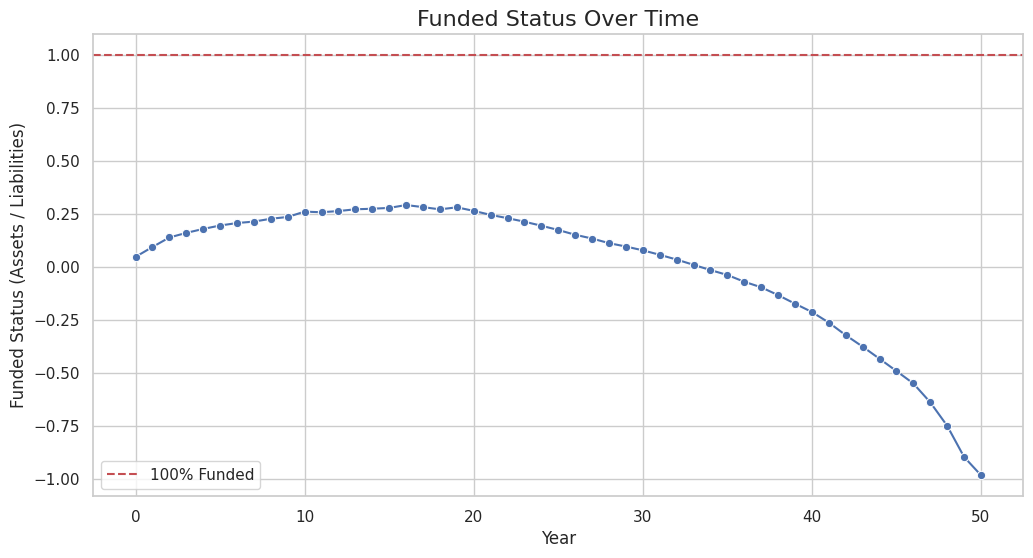

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='year', y='funded_status_boy', marker='o')
plt.title('Funded Status Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Funded Status (Assets / Liabilities)', fontsize=12)
plt.axhline(1.0, color='r', linestyle='--', label='100% Funded')
plt.legend()
plt.show()

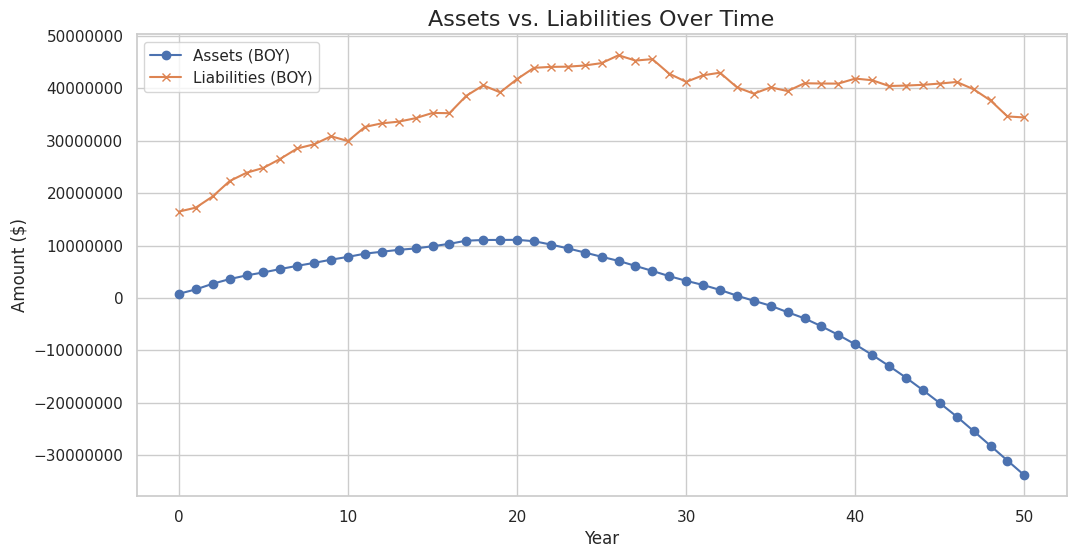

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(results_df['year'], results_df['assets_boy'], label='Assets (BOY)', marker='o')
plt.plot(results_df['year'], results_df['total_al_boy'], label='Liabilities (BOY)', marker='x')
plt.title('Assets vs. Liabilities Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Amount ($)', fontsize=12)
plt.legend()
plt.ticklabel_format(style='plain', axis='y') # Disable scientific notation
plt.show()

<Figure size 1200x600 with 0 Axes>

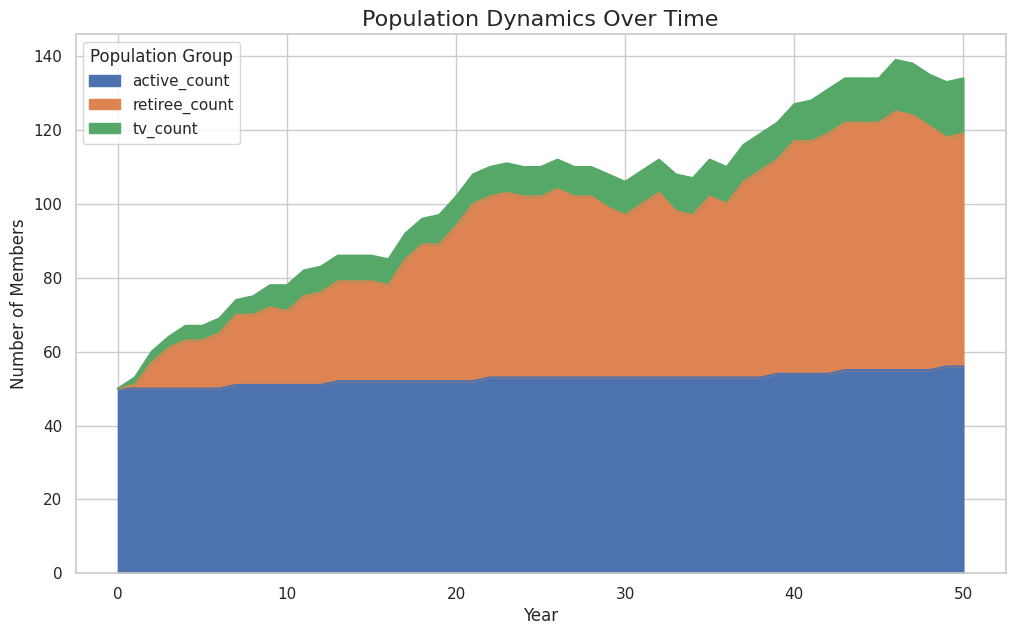

In [ ]:
plt.figure(figsize=(12, 6))
population_df = results_df[['year', 'active_count', 'retiree_count', 'tv_count']]
population_df.set_index('year').plot(kind='area', stacked=True, figsize=(12, 7))
plt.title('Population Dynamics Over Time', fontsize=16)
plt.ylabel('Number of Members', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(title='Population Group')
plt.show()